In [32]:
from scipy.stats import nbinom,poisson,beta,expon,gamma,betaprime,uniform, cauchy, norm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.integrate import quad
from scipy.optimize import fixed_point
from scipy.special import gammaln,logsumexp
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Theoric

In [7]:
from scipy.special import factorial, gammaln,comb, betaln

def combln(n, k):
    return gammaln(n+1) - gammaln(k+1) - gammaln(n-k+1)

In [8]:
def logBF_theo_y(y):
    N = len(y)
    S = np.sum(y)
    return gammaln(N+S+2)-(S+1)*np.log(N+1)-np.sum(gammaln(y+1))-gammaln(N+1)

def logBF_theo_S(S,N):
    return (S-1)*np.log(N)+np.log(N+S)+np.log(N+S+1)-(S+1)*np.log(N+1)

In [9]:
# def BF_theo_pois_nb(y,r=1):
#     N = len(y)
#     S = np.sum(y)
#     if r!=1: 
#         return factorial(S)/((N+1)**(S+1)*np.prod(factorial(y))*np.prod(comb(y+r-1,y))*beta(1+N*r-S,S+1))
#     else:
#         return factorial(S)/(N+1)**(S+1)/np.prod(factorial(y))/beta(1+N,S+1)
    
def logBF_theo_pois_nb(y,r=1):
    N=len(y)
    S=np.sum(y)
    if r!=1:
        return gammaln(S+1)-(S+1)*np.log(N+1)-np.sum(gammaln(y+1))-np.sum(gammaln(y+r)-gammaln(y+1))-gammaln(S+1)-betaln(1+N*r-S,S+1)
    else:
        return gammaln(S+1)-(S+1)*np.log(N+1)-np.sum(gammaln(y+1))-betaln(1+N,S+1)

In [10]:
# def BF_S_theo_pois_nb(S,N,r=1):
#     if r!=1:
#         return N**S/((N+1)**(S+1)*beta(1+N*r,S+1)*comb(N*r+S-1,S))
#     else:
#         return N**S/((N+1)**(S+1)*beta(1+N,S+1)*comb(N+S-1,S))
    
def logBF_S_theo_pois_nb(S,N,r=1):
    if r!=1:
        return S*np.log(N)-(S+1)*np.log(N+1)-betaln(1+N*r,S+1)-np.log(comb(N*r+S-1,S))
    else:
        return S*np.log(N)-(S+1)*np.log(N+1)-betaln(N+1,S+1)-combln(N+S-1,S)

In [11]:
def logBF_S(S,N):
    I_1 = quad(lambda mu: np.exp(-mu*(N+1))*mu**S, 0, np.inf)[0]
    I_2 = quad(lambda p: p**N*(1-p)**(S), 0, 1)[0]
    c_1 = N**S/factorial(S)
    c_2 = comb(N+S-1,S)
    
    return I_1*c_1/I_2/c_2

## Bridge

In [12]:

from scipy.optimize import fixed_point
from scipy.special import logsumexp
def func_logBF_logsumexp(logBF,lratio_num,lratio_den):
    num_j = np.array([logsumexp([0,logBF+lratio_num[j]]) for j in range(len(lratio_num))])
    den_i = np.array([logsumexp([lratio_den[i],logBF]) for i in range(len(lratio_den))])
    num = logsumexp(-num_j)
    den = logsumexp(-den_i)
    return num-den

def logBF_logsumexp_fixedpoint(lratio_num,lratio_den):
    return fixed_point(func_logBF_logsumexp,0,args=(lratio_num,lratio_den))

In [13]:
def func_r_paper(r,l1,l2,lstar):
    lstar = np.median(l1)
    return np.sum(np.exp(l2-lstar)/(np.exp(l2-lstar)+r))/np.sum(1/(np.exp(l1-lstar)+r))


def BF_paper(l1,l2):
    lstar = np.median(l1)
    r = fixed_point(func_r_paper,np.exp(-lstar),args=(l1,l2,lstar))
    BF = r*np.exp(lstar)
    return BF
    
# def fixedpoint(func,x0,args,eps=1e-4,max_iter=100000):
#     res = [np.inf,x0]
#     while np.abs(res[-1]-res[-2])>eps and len(res)<max_iter:
#         res.append(func(res[-1],*args)) 
#     return res
        
        
# def BF_paper_test(l1,l2):
#     lstar = np.median(l1)
#     r = fixedpoint(func_r_paper,np.exp(-lstar),args=(l1,l2,lstar))
#     BF = np.array(r)*np.exp(lstar)
#     return BF

def func_r_paper2(logBF,l1,l2):
    num_j = np.array([logsumexp([0,logBF-l2[j]]) for j in range(len(l2))])
    den_i = np.array([logsumexp([l1[i],logBF]) for i in range(len(l1))])
    num = logsumexp(-num_j)
    den = logsumexp(-den_i)
    return num-den


def logBF_paper(l1,l2):
    logBF = fixed_point(func_r_paper2,0,args=(l1,l2),maxiter=1000)
    return logBF

In [14]:
def logratio_pois_nb_slow(mu,y):
    return np.sum(poisson(mu=mu).logpmf(y)-nbinom(n=1,p=1/(1+mu)).logpmf(y))+expon.logpdf(mu)+2*np.log(1+mu)

In [15]:
def logratio_pois_nb(mu,y):
    return -mu*(len(y)+1)+(len(y)+sum(y)+2)*np.log(1+mu)-np.sum(gammaln(y+1))

In [16]:
from scipy.stats import multinomial
def sample_X_poiss_given_S(S,N,T):
    return multinomial.rvs(n=S, p=[1/N]*N,size=T)
    
# def sample_X_nbinom_given_S(S,N,T):
#     res=[]
#     for _ in range(T):
#         vect = np.zeros(N)
#         index,counts  = np.unique(np.random.choice(N, S, replace=True), return_counts=True)
#         vect[index] = counts
#         res.append(vect)
    
#     return np.array(res).squeeze() 



In [28]:
def sample_nbinom(S,N):
    vect = np.zeros(N+S-1)
    index = np.random.choice(N+S-1,N-1, replace=False)
    vect[index] = 1
    res = []
    i=0
    count = 0
    for i in range(N+S-1):
        if vect[i]==0:
            count+=1
        else:
            res.append(count)
            count = 0
    res.append(count)
        

    return np.array(res)



def sample_nbinom(S,N):
    index = np.random.choice(N+S-1,N-1, replace=False)
    vect = np.append(np.sort(index),N+S-1)
    vect = np.append(-1,vect)
    return vect[1:]-vect[:-1]-1

def sample_X_nbinom_given_S(S,N,T):
    return np.array([sample_nbinom(S,N) for _ in range(T)]) 

In [25]:
def post_p_nbinom_unif(S,N,size):
    return beta(1+N,S+1).rvs(size)

def post_nbinom_unif(S,N,size):
    return betaprime(S+1,N+1).rvs(size)

def post_pois_exp(S,N,size):
    return gamma(S+1,scale=1/(N+1)).rvs(size)

In [30]:
def func_BF(args):
    np.random.seed()
    i,S,N,T = args
    X_poiss_S = sample_X_poiss_given_S(S,N,T)
    X_nb_S = sample_X_nbinom_given_S(S,N,T)
    mu_poiss = post_pois_exp(S,N,T)
    mu_nb = post_nbinom_unif(S,N,T)
    l1 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_poiss_S)])
    l2 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_nb,X_nb_S)])

    Bridge = BF_paper(l1,l2)
    logBridge = logBF_paper(l1,l2)
    return Bridge,logBridge

In [29]:
%lprun -f func_BF func_BF((9,1000,10000,1000))

Timer unit: 1e-09 s

Total time: 2.68764 s
File: /var/folders/bk/dp9d4fpn6c9_mvvkgvwr5ry40000gq/T/ipykernel_50518/754791662.py
Function: func_BF at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def func_BF(args):
     2         1     275000.0 275000.0      0.0      np.random.seed()
     3         1          0.0      0.0      0.0      i,S,N,T = args
     4         1  259534000.0    3e+08      9.7      X_poiss_S = sample_X_poiss_given_S(S,N,T)
     5         1  507255000.0    5e+08     18.9      X_nb_S = sample_X_nbinom_given_S(S,N,T)
     6         1     804000.0 804000.0      0.0      mu_poiss = post_pois_exp(S,N,T)
     7         1     710000.0 710000.0      0.0      mu_nb = post_nbinom_unif(S,N,T)
     8         1  785972000.0    8e+08     29.2      l1 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_poiss_S)])
     9         1  778515000.0    8e+08     29.0      l2 = np.array([logratio_pois_nb(mu,

In [835]:
test = sample_X_nbinom_given_S(3,2,100000)

In [836]:
np.unique(test,axis=0,return_counts=True)

(array([[0., 3.],
        [1., 2.],
        [2., 1.],
        [3., 0.]]),
 array([12470, 37356, 37583, 12591]))

In [779]:
def log_pi_tilde_mu_nb(mu,S,N):
    return -(N+S+2)*np.log(1+mu)+S*np.log(mu)

def MH_post_nb(S,N,T,std):
    mu = S/N 
    mu_list = [mu]
    for t in tqdm(range(T)):
        mu_star = np.random.normal(mu,std)
        logratio = log_pi_tilde_mu_nb(mu_star,S,N)-log_pi_tilde_mu_nb(mu,S,N)
        if np.log(np.random.uniform())<logratio:
            mu = mu_star
        mu_list.append(mu)
    mu_list = np.array(mu_list)
    print(len(np.unique(mu_list))/T)
    return mu_list

In [995]:
def Bridge_S(S,N,T=1000,plot=True, verbose=True):
    X_S_pois= sample_X_poiss_given_S(S,N,T)
    X_S_nb = sample_X_nbinom_given_S(S,N,T)
    
    mu_poiss = post_pois_exp(S,N,T)
    mu_nb = post_nbinom_unif(S,N,T)
    if plot:
        sns.kdeplot(mu_poiss, label="Posterior Poisson")
        sns.kdeplot(mu_nb, label="Posterior Negative Binomial")
        plt.legend()
        plt.show()
    lratio_num = -np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_nb,X_S_nb)])
    lratio_den = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_S_pois)])
    Theo_S = logBF_S_theo_pois_nb(S,N)
    Bridge_S = logBF_logsumexp_fixedpoint(lratio_num,lratio_den)
    print("Theoretical logBF: {}".format(Theo_S))
    print("Bridge logBF: {}".format(Bridge_S))
    
    return Bridge_S
    

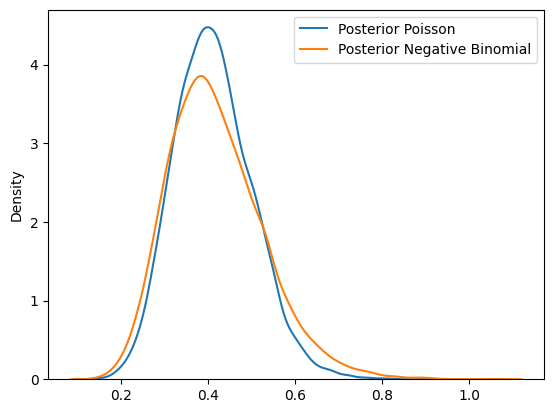

Theoretical logBF: 0.27127393501456964
Bridge logBF: 0.28232672943046855


In [1001]:
test = Bridge_S(20,50,T=10000,plot=True,verbose=True)

Min = 0.00012896963044317644, Max = 0.9997950069068584


(0.010101010101011079, 99.00000000000017)

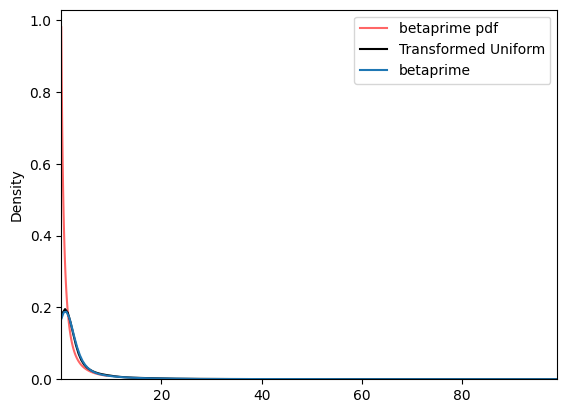

In [819]:
T = 10000
p = uniform.rvs(size=T)
print("Min = {}, Max = {}".format(np.min(p),np.max(p)))
mu = p/(1-p)
mu3 = betaprime(1,1).rvs(size=T)

mu= mu[mu<100]
mu3 = mu3[mu3<100]
law = betaprime(1,1)
x = np.linspace(law.ppf(0.01),law.ppf(0.9), 100)
plt.plot(x, law.pdf(x), 'r-', alpha=0.6, label='betaprime pdf')

sns.kdeplot(mu, color = "black", label="Transformed Uniform")
sns.kdeplot(mu3, label="betaprime")


plt.legend()
plt.xlim(law.ppf(0.01),law.ppf(0.99))


# Probleme $\mu\mid y \sim$ ? 

  0%|          | 0/100000 [00:00<?, ?it/s]/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
100%|██████████| 100000/100000 [00:00<00:00, 144949.36it/s]


0.66566


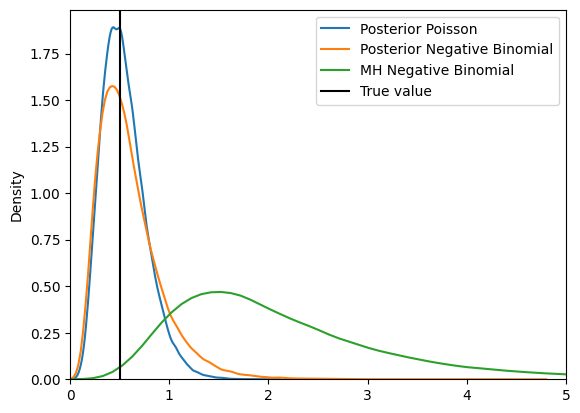

In [754]:
S,N = 5,10
T = 100000
mu_poiss = post_pois_exp(S,N,T)
p_nb = post_nbinom_unif(S,N,T)
mu_nb = (1-p_nb)/p_nb
mu_nb2 = MH_post_nb(S,N,T,1)

sns.kdeplot(mu_poiss, label="Posterior Poisson")
sns.kdeplot(mu_nb, label="Posterior Negative Binomial")
sns.kdeplot(mu_nb2, label="MH Negative Binomial")
plt.axvline(S/N, color="black", label="True value")
#plt.axvline((N+1)/(N+S+2), color="black", linestyle="--", label="Theoretical value")
plt.xlim(0,5)
plt.legend()

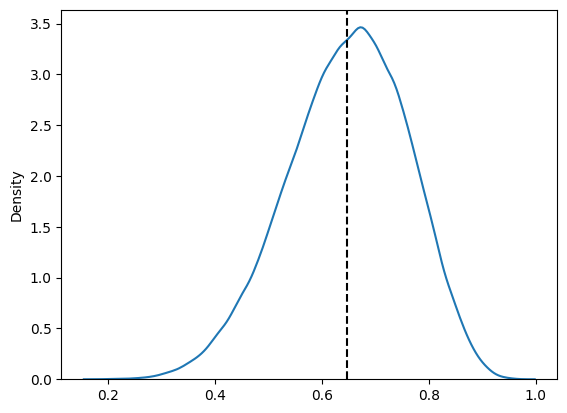

In [738]:
sns.kdeplot(p_nb, label="Posterior Negative Binomial")
plt.axvline((N+1)/(N+S+2), color="black", linestyle="--", label="Theoretical value")

In [720]:
 Python3 Program to find the number 
# of arrays of size N whose elements 
# are positive integers and sum is K
 
# Return nCr
def binomialCoeff(n, k):
 
    C = [0] * (k + 1);
     
    C[0] = 1; # nC0 is 1
 
    for i in range(1, n + 1):
 
        # Compute next row of pascal 
        # triangle using the previous row
        for j in range(min(i, k), 0, -1):
            C[j] = C[j] + C[j - 1];
    return C[k];
 
# Return the number of array that 
# can be formed of size n and 
# sum equals to k.
def countArray(N, K):
 
    return binomialCoeff(K - 1, N - 1);
 
# Driver Code
N = 2;
K = 3;
 
print(countArray(N, K));
 
# This code is contributed by mits

SyntaxError: invalid syntax (1359496805.py, line 1)

# For X 

In [310]:
from scipy.stats import nbinom,poisson,beta,expon,gamma
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

N = 1001
lamb = 1
mu = .5
r = 1

X_pois = poisson.rvs(lamb, size=N)
X_nb = nbinom.rvs(r, mu, size=N)
S_pois = np.sum(X_pois)
S_nb = np.sum(X_nb)
S_theo_pois = N*lamb
S_theo_nb = N*r*(1-mu)/mu

print("Poisson: S = {}, S_theo = {}".format(S_pois, S_theo_pois))
print("Negative Binomial: S = {}, S_theo = {}".format(S_nb, S_theo_nb))

Poisson: S = 972, S_theo = 1001
Negative Binomial: S = 983, S_theo = 1001.0


## Theoric

In [457]:
N=1000
S=500
X = sample_X_poiss_given_S(S,N)

In [458]:
theo = logBF_theo_pois_nb(X,r=r)
print("Theoretical logBF: {}".format(theo))

Theoretical logBF: 28.292589954077812


## Bridge

In [459]:
T=10000

In [460]:
mu_poisson = post_pois_unif(X,T)

In [461]:
p_nbinom = post_nbinom_unif(X,T,r=r)
mu_nbinom = p_nbinom/(1-p_nbinom)

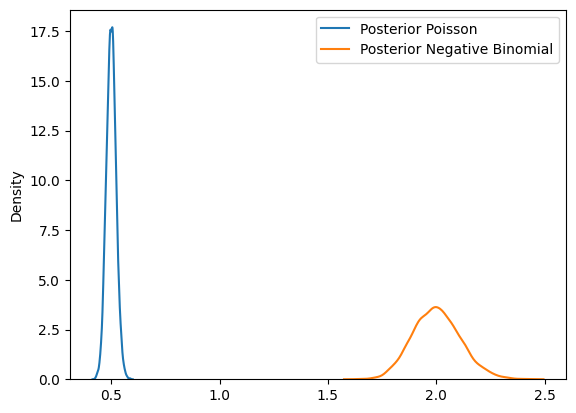

In [462]:
sns.kdeplot(mu_poisson, label="Posterior Poisson")
sns.kdeplot(mu_nbinom, label="Posterior Negative Binomial")
plt.legend()

In [463]:
lratio_num = -np.array([logratio_pois_nb(mu,X,r=r) for mu in tqdm(mu_nbinom)])
lratio_den = np.array([logratio_pois_nb(mu,X,r=r) for mu in tqdm(mu_poisson)])
print("Log Ratio NB/Poiss(mu_nb): mean = {} min = {} max = {}".format(np.mean(lratio_num),np.min(lratio_num),np.max(lratio_num)))
print("Log Ratio Poiss/NB(mu_poiss)/NB: mean = {} min = {} max = {}".format(np.mean(lratio_den),np.min(lratio_den),np.max(lratio_den)))

100%|██████████| 10000/10000 [00:01<00:00, 5552.91it/s]

Log Ratio NB/Poiss(mu_nb): mean = 434.2218639761757 min = 258.00222649134923 max = 668.2774903130188
Log Ratio Poiss/NB(mu_poiss)/NB: mean = 28.329745320110938 min = 25.995381104598298 max = 28.495516749070312


In [465]:
Bridge = logBF_logsumexp_fixedpoint(lratio_num,lratio_den)
print("Bridge logBF: {}".format(Bridge))
print("Theoretical logBF: {}".format(theo))

Bridge logBF: -119.41838252170658
Theoretical logBF: 28.292589954077812


## Comparison

In [584]:
X_Poiss = []
X_NB = []
BF_theo_pois = []
BF_bridge_pois = []
BF_bridge_nb = []
BF_theo_nb = []
N = 50
T = 10000
r= 1
p=0.5
lamb  = 1
for i in tqdm(range(10)):
    X = poisson.rvs(lamb, size=N)
    X_Poiss.append(X)
    mu_poisson = post_pois_exp(np.sum(XT)
    p_nbinom = post_nbinom_unif(X,T,r=r)
    mu_nbinom = p_nbinom/(1-p_nbinom)
    lratio_num = -np.array([logratio_pois_nb(mu,X,r=r) for mu in (mu_nbinom)])
    lratio_den = np.array([logratio_pois_nb(mu,X,r=r) for mu in (mu_poisson)])
    Bridge = logBF_logsumexp_fixedpoint(lratio_num,lratio_den)
    Theo = logBF_theo_pois_nb(X,r=r)
    BF_theo_pois.append(Theo)
    BF_bridge_pois.append(Bridge)
    
    X = nbinom.rvs(r,p, size=N)
    X_NB.append(X)
    mu_poisson = post_pois_unif(X,T)
    p_nbinom = post_nbinom_unif(X,T,r=r)
    mu_nbinom = p_nbinom/(1-p_nbinom)
    lratio_num = -np.array([logratio_pois_nb(mu,X,r=r) for mu in (mu_nbinom)])
    lratio_den = np.array([logratio_pois_nb(mu,X,r=r) for mu in (mu_poisson)])
    Bridge = logBF_logsumexp_fixedpoint(lratio_num,lratio_den)
    Theo = logBF_theo_pois_nb(X,r=r)
    BF_theo_nb.append(Theo)
    BF_bridge_nb.append(Bridge)
    
    
    


  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: post_pois_unif() missing 1 required positional argument: 'size'

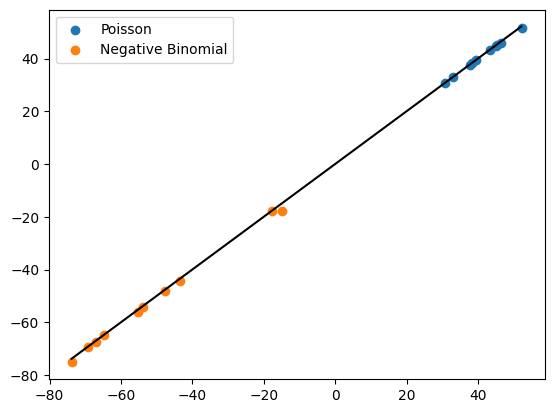

In [320]:
plt.scatter(BF_theo_pois,BF_bridge_pois, label="Poisson")
plt.scatter(BF_theo_nb,BF_bridge_nb, label="Negative Binomial")
x = np.arange(np.min(BF_theo_nb), np.max(BF_theo_pois))
plt.plot(x,x, color="black")
plt.legend()


## Theoric 

In [475]:
def logBF_S_theo(S,N):
    return (S-1)*np.log(N)-(S+1)*np.log(N+1)+np.log(N+S)+np.log(N+S+1)

In [474]:
S,N = 100,1000
print(logBF_S_theo(N,S), logBF_S_theo_pois_nb(S,N))


0.0905795039034416 0.09057950390229053


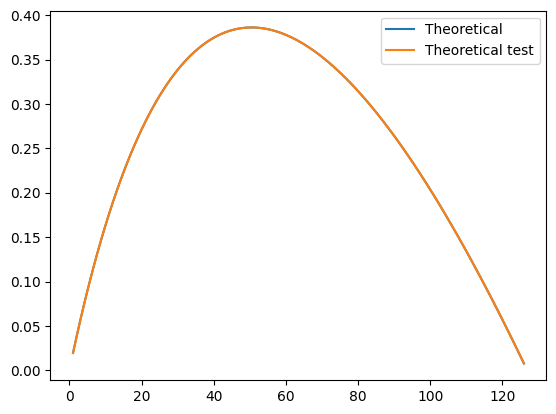

  0%|          | 0/10000 [02:21<?, ?it/s]


In [583]:
N = 50
S_list = np.arange(1, 2.54*N)
logBF_S_theo_list = [logBF_S_theo_pois_nb(S,N,r=r) for S in S_list]
test = [logBF_S_theo(S,N) for S in S_list]
plt.plot(S_list, logBF_S_theo_list, label="Theoretical")
plt.plot(S_list, test, label="Theoretical test")
plt.legend()

In [418]:
N = 1000
lamb = 2
mu = .3
r = 1

X_pois = poisson.rvs(lamb, size=N)
X_nb = nbinom.rvs(r, mu, size=N)
S_pois = np.sum(X_pois)
S_nb = np.sum(X_nb)
S_theo_pois = N*lamb
S_theo_nb = N*r*(1-mu)/mu

print("Poisson: S = {}, S_theo = {}".format(S_pois, S_theo_pois))
print("Negative Binomial: S = {}, S_theo = {}".format(S_nb, S_theo_nb))

Poisson: S = 2043, S_theo = 2000
Negative Binomial: S = 2339, S_theo = 2333.3333333333335


240.0

Proche de 0: 240.0
MAX for S = 260.0 


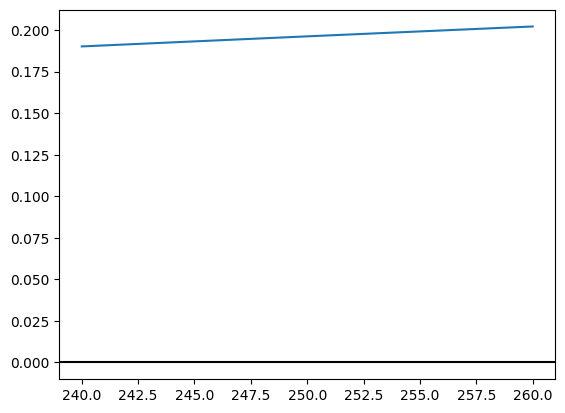

In [421]:
S_list = np.linspace(240, 260,100000)
logBF_theo= [logBF_S_theo_pois_nb(S,N) for S in S_list]
print("Proche de 0: {}".format(S_list[np.argmin(np.abs(logBF_theo))]))
print("MAX for S = {} ".format(S_list[np.argmax(logBF_theo)]))
plt.plot(S_list, [logBF_S_theo_pois_nb(S,N) for S in S_list], label="Poisson")
plt.axhline(0, color="black")

In [404]:
S=1500
T=10000
N = 1000

In [405]:
X_S_pois= [sample_X_poiss_given_S(N,S) for t in tqdm(range(T))]
X_S_nb = [sample_X_nbinom_given_S(N,S,r=r) for t in tqdm(range(T))]


100%|██████████| 10000/10000 [00:00<00:00, 11840.29it/s]


In [398]:
np.sum(np.array(X_S_nb), axis=1), np.sum(np.array(X_S_pois), axis=1)

(array([500., 500., 500., ..., 500., 500., 500.]),
 array([500, 500, 500, ..., 500, 500, 500]))

In [406]:
mu_S_pois = np.array([post_pois_unif(X,1) for X in tqdm(X_S_pois)]).reshape(-1)
p_S_nb = np.array([post_nbinom_unif(X,1,r=r) for X in tqdm(X_S_nb)]).reshape(-1)
mu_S_nb = (1-p_S_nb)/p_S_nb

100%|██████████| 10000/10000 [00:03<00:00, 2879.81it/s]


In [425]:
import scipy

In [486]:
N=100
S=40

In [499]:
N=25
S=10
quad(lambda p: p**N*(1-p)**(S), 0, 1)[0],quad(lambda mu: mu**S*(1+mu)**(-(N+S+2)), 0,100000)[0],scipy.special.beta(N+1,S+1)

(1.513120665403221e-10, 2.261180005543264e-53, 1.5131206651196181e-10)

In [408]:
def post_mu_nb(mu,N,S):
    return (1+mu)**-(N+S+2)*mu**S

In [522]:
def MH_post_nb(S,N,T,std):
    mu_list = [S/N]
    for t in tqdm(range(T)):
        mu_star = np.random.normal(mu,std)
        logratio = log_pi_tilde_mu_nb(mu_star,N,S)-log_pi_tilde_mu_nb(mu,N,S)
        if np.log(np.random.uniform())<logratio:
            mu = mu_star
        
        mu_list.append(mu)
    mu_list = np.array(mu_list)
    print(len(np.unique(mu_list))/T)
    return mu_list

In [412]:
mu_nb = MH_post_nb(.5,N,S,T,.05)

100%|██████████| 10000/10000 [00:00<00:00, 125156.03it/s]

0.7456


/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  
/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


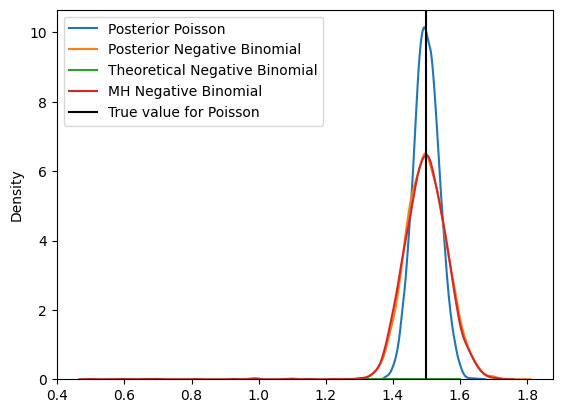

In [413]:
sns.kdeplot(mu_S_pois, label="Posterior Poisson")
sns.kdeplot(mu_S_nb, label="Posterior Negative Binomial")
x=np.linspace(np.min(mu_S_nb),np.max(mu_S_pois),100)
plt.plot(x,post_mu_nb(x,N,S), label="Theoretical Negative Binomial")
sns.kdeplot(mu_nb, label="MH Negative Binomial")
plt.axvline(S/N, color="black", label="True value for Poisson")
plt.legend()

In [502]:
lratio_num = -np.array([logratio_pois_nb(mu,X,r=r) for mu,X in tqdm(zip(mu_S_nb,X_S_nb))])
lratio_den = np.array([logratio_pois_nb(mu,X,r=r) for mu,X in tqdm(zip(mu_S_pois,X_S_pois))])

print("Log Ratio NB/Poiss(mu_nb): mean = {} min = {} max = {}".format(np.mean(lratio_num),np.min(lratio_num),np.max(lratio_num)))
print("Log Ratio Poiss/NB(mu_poiss)/NB: mean = {} min = {} max = {}".format(np.mean(lratio_den),np.min(lratio_den),np.max(lratio_den)))

10000it [00:00, 30596.29it/s]
10000it [00:00, 30212.67it/s]

Log Ratio NB/Poiss(mu_nb): mean = -143.04648747003623 min = -200.50619362166344 max = -91.67131705147358
Log Ratio Poiss/NB(mu_poiss)/NB: mean = 143.59957500244255 min = 87.72919296987175 max = 202.54028672164623


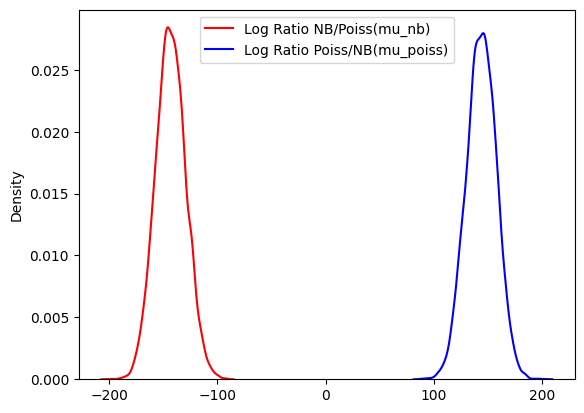

In [503]:
sns.kdeplot(lratio_num, label="Log Ratio NB/Poiss(mu_nb)", color="red")
sns.kdeplot(lratio_den, label="Log Ratio Poiss/NB(mu_poiss)",color="blue")
plt.legend()

In [504]:
theo = logBF_S_theo_pois_nb(S,N,r=r)
print("Theoretical logBF: {}".format(theo))
bridge = logBF_logsumexp_fixedpoint(lratio_num,lratio_den)
print("Bridge logBF: {}".format(bridge))

Theoretical logBF: 0.26968750552304144
Bridge logBF: 143.50057985418073


In [577]:
test = Bridge_S(100,1000,plot=True,verbose=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

TypeError: sample_X_nbinom_given_S() missing 1 required positional argument: 'T'

<BarContainer object of 50 artists>

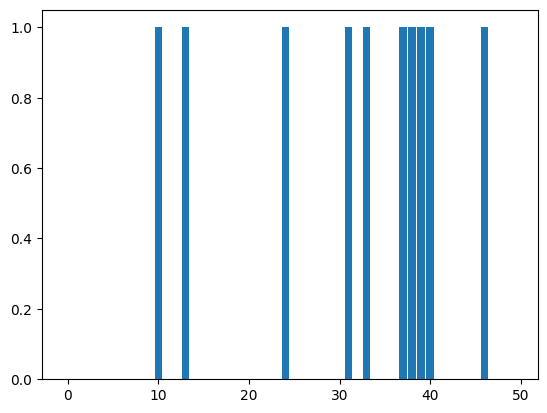

In [607]:
X_S_pois

array([[0, 0, 1, ..., 0, 1, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 1, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

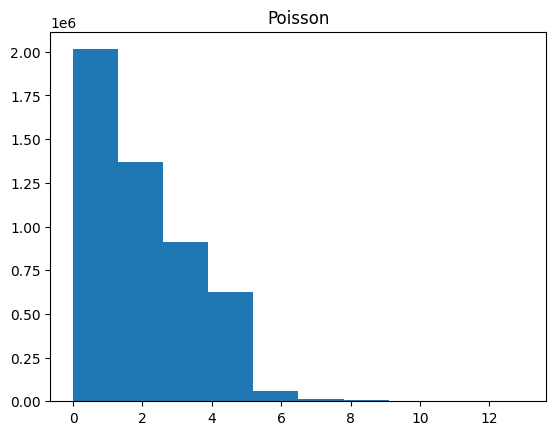

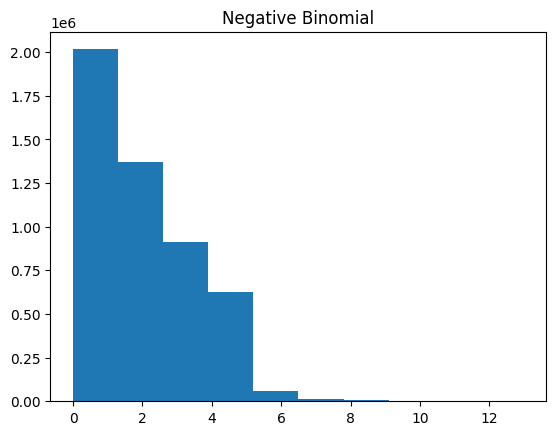

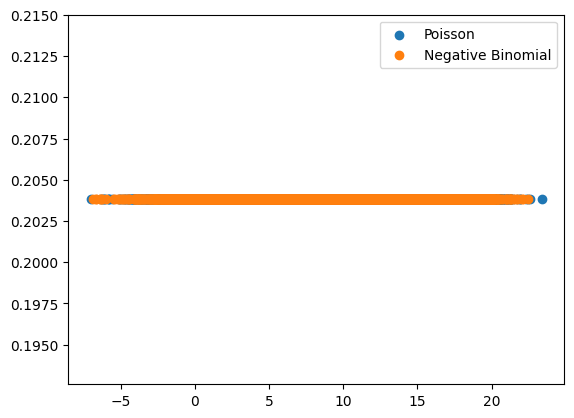

In [608]:
S = 100
N = 50
T=100000
X_S_pois= sample_X_poiss_given_S(S,N,T)
X_S_nb = sample_X_nbinom_given_S(S,N,T)
plt.hist(X_S_pois.reshape(-1)),
plt.title("Poisson")
plt.show()
plt.hist(X_S_nb.reshape(-1))
plt.title("Negative Binomial")
plt.show()

mu_poisson = post_pois_exp(S,N,T)
p_nb = post_nbinom_unif(S,N,T)
mu_nb = p_nb/(1-p_nb)

lbf_theo_pois = [logBF_theo_pois_nb(X,r=r) for X in X_S_pois]
lbf_theo_nb = [logBF_theo_pois_nb(X,r=r) for X in X_S_nb]

theo_S = logBF_S_theo_pois_nb(S,N,r=r)


plt.scatter(lbf_theo_pois,[theo_S]*len(lbf_theo_pois), label="Poisson")
plt.scatter(lbf_theo_nb,[theo_S]*len(lbf_theo_nb), label="Negative Binomial")
plt.legend()


# ABC

In [615]:
p = np.random.uniform(0,1, size=T//2)
print(p)
X_nb = nbinom.rvs(1,p, size=(N,T//2))
print("X_nb shape: {}".format(X_nb.shape))

[0.42147182 0.06853435 0.66716508 ... 0.91474889 0.71377307 0.14312536]
X_nb shape: (50, 50000)


In [1009]:
p = [.01,.99]
X_nb = nbinom.rvs(1,p, size=(10,2))
X_nb

array([[196,   0],
       [141,   0],
       [ 15,   0],
       [ 17,   0],
       [ 45,   0],
       [ 16,   0],
       [ 13,   0],
       [140,   0],
       [129,   1],
       [ 26,   0]])

In [1013]:
def ABC_Model(S,N,T,eps=.01):
    p = np.random.uniform(size=T//2)
    X_nb = nbinom.rvs(1,p, size=(N,T//2))
    print("X_nb shape: {}".format(X_nb.shape))
    S_nb = np.sum(X_nb, axis=0)
    print("S_nb shape: {}".format(S_nb.shape))
    d_nb = (S_nb-S)**2
    
    mu = expon(1).rvs(T//2)
    X_pois = poisson.rvs(mu, size=(N,T//2))
    print("X_pois shape: {}".format(X_pois.shape))
    S_pois = np.sum(X_pois, axis=0)
    d_pois = np.abs(S_pois-S)**2
    
    
    dist = np.concatenate([d_nb,d_pois])
    epsilon = np.quantile(dist,eps)
    pM1 = np.sum(d_nb<epsilon)
    pM2 = np.sum(d_pois<epsilon)
    print("pM1 = {} pM2 = {}".format(pM1/np.sum(dist<epsilon),pM2/np.sum(dist<epsilon)))
    return pM1/pM2
    

In [1014]:
S,N,T = 100, 100, 10000
ABC = [ABC_Model(S,N,T) for _ in range(1)]

X_nb shape: (100, 5000)
S_nb shape: (5000,)
X_pois shape: (100, 5000)
pM1 = 0.3333333333333333 pM2 = 0.6666666666666666


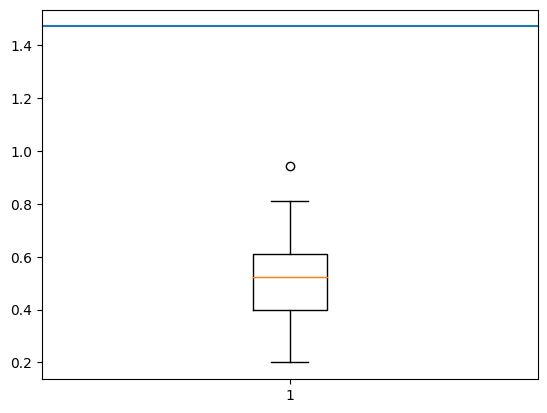

In [750]:
plt.boxplot(ABC)
plt.axhline(np.exp(logBF_S_theo(S,N)))

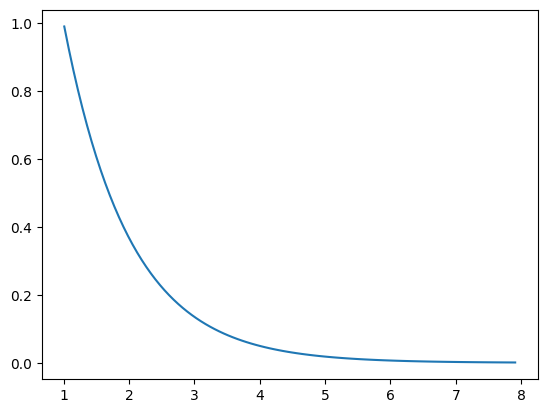

In [700]:
law = expon(1)
x=np.linspace(law.ppf(0.01),law.ppf(0.999), 100)
plt.plot(x,law.pdf(x))


# Paper 

In [1034]:
N = 50
n_iter= 100
T = 10000
Theo_Poiss, Theo_NB, Bridge_Poiss, Bridge_NB = [],[],[],[]
for _ in tqdm(range(n_iter)):
    p = np.random.uniform(size=1)
    X_nb = nbinom.rvs(1,p, size=N)
    S_nb = np.sum(X_nb)
    theo_nb = logBF_theo_S(S_nb,N)
    mu_nb = post_nbinom_unif(S_nb,N,T)
    mu_poiss = post_pois_exp(S_nb,N,T)
    X_nb_S_nb = sample_X_nbinom_given_S(S_nb,N,T)
    X_pois_S_nb = sample_X_poiss_given_S(S_nb,N,T)
    lratio_num = -np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_nb,X_nb_S_nb)])
    lratio_den = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_pois_S_nb)])
    Bridge_nb = logBF_logsumexp_fixedpoint(lratio_num,lratio_den)
    print("Nbinom S = {} Theoretical logBF = {} Bridge logBF = {}".format(S_nb,theo_nb,Bridge_nb))
    
    mu = expon(1).rvs(1)
    X_pois = poisson.rvs(mu, size=N)
    S_pois = np.sum(X_pois)
    theo_pois = logBF_theo_S(S_pois,N)
    mu_nb = post_nbinom_unif(S_pois,N,T)
    mu_poiss = post_pois_exp(S_pois,N,T)
    X_nb_S_pois = sample_X_nbinom_given_S(S_pois,N,T)
    X_pois_S_pois = sample_X_poiss_given_S(S_pois,N,T)
    
    lratio_num = -np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_nb,X_nb_S_pois)])
    lratio_den = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_pois_S_pois)])
    Bridge_pois = logBF_logsumexp_fixedpoint(lratio_num,lratio_den)
    print("Poisson S = {} Theoretical logBF = {} Bridge logBF = {}".format(S_pois,theo_pois,Bridge_pois))
    
    Bridge_Poiss.append(Bridge_pois)
    Bridge_NB.append(Bridge_nb)
    Theo_Poiss.append(theo_pois)
    Theo_NB.append(theo_nb)
    
    

  0%|          | 0/100 [00:00<?, ?it/s]

Nbinom S = 6 Theoretical logBF = 0.10573855664014786 Bridge logBF = 0.09990159752135597


  1%|          | 1/100 [00:08<14:29,  8.78s/it]

Poisson S = 71 Theoretical logBF = 0.34997641414878444 Bridge logBF = 0.3254245009520655
Nbinom S = 21 Theoretical logBF = 0.27964218468513025 Bridge logBF = 0.2816767491912496


  2%|▏         | 2/100 [00:17<14:17,  8.74s/it]

Poisson S = 80 Theoretical logBF = 0.31467295180993915 Bridge logBF = 0.33841047588770257
Nbinom S = 3 Theoretical logBF = 0.05601944007538506 Bridge logBF = 0.05835467755489529


  3%|▎         | 3/100 [00:25<13:40,  8.46s/it]

Poisson S = 132 Theoretical logBF = -0.044302601329832214 Bridge logBF = -0.0755994829589053
Nbinom S = 66 Theoretical logBF = 0.3649420862038255 Bridge logBF = 0.3544545119739775


  4%|▍         | 4/100 [00:34<13:49,  8.64s/it]

Poisson S = 101 Theoretical logBF = 0.1972463625945693 Bridge logBF = 0.20846921092057136
Nbinom S = 204 Theoretical logBF = -0.8049867943960862 Bridge logBF = -1.2378202647240188


  5%|▌         | 5/100 [00:44<14:22,  9.08s/it]

Poisson S = 59 Theoretical logBF = 0.37962459939450355 Bridge logBF = 0.36732019743324784
Nbinom S = 6 Theoretical logBF = 0.10573855664014786 Bridge logBF = 0.10506990386299726


  6%|▌         | 6/100 [00:52<13:51,  8.85s/it]

Poisson S = 103 Theoretical logBF = 0.18387127414706583 Bridge logBF = 0.21843674358909274
Nbinom S = 3 Theoretical logBF = 0.05601944007538506 Bridge logBF = 0.05620844413786585


  7%|▋         | 7/100 [01:01<13:32,  8.73s/it]

Poisson S = 130 Theoretical logBF = -0.02673630449976372 Bridge logBF = 0.1514048587999915
Nbinom S = 49 Theoretical logBF = 0.38611266045739967 Bridge logBF = 0.3860529187379246


  8%|▊         | 8/100 [01:10<13:24,  8.74s/it]

Poisson S = 81 Theoretical logBF = 0.3101377966445398 Bridge logBF = 0.24363522347709843
Nbinom S = 206 Theoretical logBF = -0.8289363317907146 Bridge logBF = 0.9508456995105167


  9%|▉         | 9/100 [01:19<13:41,  9.02s/it]

Poisson S = 56 Theoretical logBF = 0.3834721618354422 Bridge logBF = 0.41053259126042185
Nbinom S = 28 Theoretical logBF = 0.3278344767111179 Bridge logBF = 0.2995342466931124


 10%|█         | 10/100 [01:28<13:39,  9.10s/it]

Poisson S = 253 Theoretical logBF = -1.4231528371703916 Bridge logBF = -3.59440722538382
Nbinom S = 14 Theoretical logBF = 0.21218493295631902 Bridge logBF = 0.20434347698053193


 11%|█         | 11/100 [01:37<13:20,  9.00s/it]

Poisson S = 85 Theoretical logBF = 0.2908577058467472 Bridge logBF = 0.2781671418231726
Nbinom S = 775 Theoretical logBF = -9.758906632835533 Bridge logBF = -14.473635925337407


 12%|█▏        | 12/100 [01:48<13:47,  9.40s/it]

Poisson S = 74 Theoretical logBF = 0.3393522448376416 Bridge logBF = 0.3239485775217972
Nbinom S = 15 Theoretical logBF = 0.22315396432689738 Bridge logBF = 0.2251403019866487


 13%|█▎        | 13/100 [01:57<13:28,  9.29s/it]

Poisson S = 52 Theoretical logBF = 0.3861165439600711 Bridge logBF = 0.43236665467963004
Nbinom S = 14 Theoretical logBF = 0.21218493295631902 Bridge logBF = 0.2125236520615551


 14%|█▍        | 14/100 [02:06<13:13,  9.23s/it]

Poisson S = 60 Theoretical logBF = 0.37800429118149736 Bridge logBF = 0.37155638189900353
Nbinom S = 8 Theoretical logBF = 0.1357107979302299 Bridge logBF = 0.1315940062459049


 15%|█▌        | 15/100 [02:15<13:03,  9.21s/it]

Poisson S = 114 Theoretical logBF = 0.10446375180782752 Bridge logBF = 0.011994390410783913
Nbinom S = 256 Theoretical logBF = -1.4628883764349894 Bridge logBF = -3.167310166098693


 16%|█▌        | 16/100 [02:25<13:22,  9.56s/it]

Poisson S = 177 Theoretical logBF = -0.4946180231404469 Bridge logBF = -0.3796022962308926
Nbinom S = 37 Theoretical logBF = 0.36669908502167914 Bridge logBF = 0.3949586178905262


 17%|█▋        | 17/100 [02:35<13:14,  9.57s/it]

Poisson S = 184 Theoretical logBF = -0.572625431147685 Bridge logBF = -1.5910325644227146
Nbinom S = 147 Theoretical logBF = -0.18336409125822684 Bridge logBF = -0.5053467850158982


 18%|█▊        | 18/100 [02:44<12:48,  9.37s/it]

Poisson S = 54 Theoretical logBF = 0.3851607371527166 Bridge logBF = 0.40590269484931785
Nbinom S = 127 Theoretical logBF = -0.0008490219013879141 Bridge logBF = 0.26384997984364555


 19%|█▉        | 19/100 [02:53<12:27,  9.23s/it]

Poisson S = 76 Theoretical logBF = 0.33162068074796025 Bridge logBF = 0.32295678120494564
Nbinom S = 44 Theoretical logBF = 0.38200743468618725 Bridge logBF = 0.3820944534909465


 20%|██        | 20/100 [03:02<12:14,  9.18s/it]

Poisson S = 182 Theoretical logBF = -0.5501509808250375 Bridge logBF = -1.048937681033456
Nbinom S = 1 Theoretical logBF = 0.019418085857101808 Bridge logBF = 0.019302076760920883


 21%|██        | 21/100 [03:11<12:03,  9.16s/it]

Poisson S = 221 Theoretical logBF = -1.0123083834325826 Bridge logBF = -1.3160997446842277
Nbinom S = 121 Theoretical logBF = 0.04919149232586051 Bridge logBF = 0.060241012754520956


 22%|██▏       | 22/100 [03:20<11:56,  9.18s/it]

Poisson S = 152 Theoretical logBF = -0.232374310728801 Bridge logBF = -0.10103898646281446
Nbinom S = 72 Theoretical logBF = 0.3465675966282902 Bridge logBF = 0.39331742026464095


 23%|██▎       | 23/100 [03:29<11:43,  9.13s/it]

Poisson S = 51 Theoretical logBF = 0.38631069986792 Bridge logBF = 0.35159921836960617
Nbinom S = 51 Theoretical logBF = 0.38631069986792 Bridge logBF = 0.422874215439518


 24%|██▍       | 24/100 [03:38<11:27,  9.05s/it]

Poisson S = 55 Theoretical logBF = 0.3844063048272517 Bridge logBF = 0.3431522343138405


 24%|██▍       | 24/100 [03:42<11:43,  9.26s/it]


KeyboardInterrupt: 

# N = 50

In [1497]:
N =50
S = 50
T=1000

X_poiss_S = sample_X_poiss_given_S(S,N,T)
X_nb_S = sample_X_nbinom_given_S(S,N,T)

mu_poiss = post_pois_exp(S,N,T)
mu_nb = post_nbinom_unif(S,N,T)

l1 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_poiss_S)])
l2 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_nb,X_nb_S)])


l1bis = np.array([logratio_pois_nb_test(mu,X) for mu,X in zip(mu_poiss,X_poiss_S)])
l2bis = np.array([logratio_pois_nb_test(mu,X) for mu,X in zip(mu_nb,X_nb_S)])

BF_paper(l1,l2),BF_paper(l1bis,l2bis),np.exp(logBF_theo_S(S,N))

(1.504744235895912, 1.5047442358959127, 1.4715418076401625)

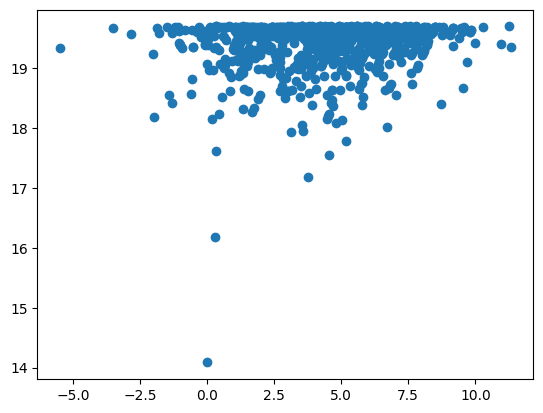

In [1494]:
plt.scatter(l1,l1bis)

In [1471]:
N = 50 
S_list = np.arange(0,4*N+1,(4*N)/20).astype(int)
T = 1000
n_iter = 1
Theo_listbis, Bridge_listbis = [],[]
for S in tqdm(S_list):
    Bridge_S =[]
    Theo = np.exp(logBF_theo_S(S,N))
    for _ in tqdm(range(n_iter)):
        X_poiss_S = sample_X_poiss_given_S(S,N,T)
        X_nb_S = sample_X_nbinom_given_S(S,N,T)
        mu_poiss = post_pois_exp(S,N,T)
        mu_nb = post_nbinom_unif(S,N,T)
        l1 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_nb,X_nb_S)])
        l2 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_poiss_S)])
        Bridge = BF_paper(l1,l2)
        Bridge_S.append(Bridge)
    
    print("S = {} Theoretical logBF = {} Bridge logBF = {}".format(S,Theo,np.mean(Bridge_S)))
    Theo_listbis.append(Theo)
    Bridge_listbis.append(Bridge_S)

  5%|▍         | 1/21 [00:01<00:29,  1.47s/it]

S = 0 Theoretical logBF = 1.0 Bridge logBF = 1.0002302824982587


 10%|▉         | 2/21 [00:02<00:27,  1.45s/it]

S = 10 Theoretical logBF = 1.1774410892325742 Bridge logBF = 1.1954474995111493


 14%|█▍        | 3/21 [00:04<00:26,  1.45s/it]

S = 20 Theoretical logBF = 1.3116343237439545 Bridge logBF = 1.281680093268881


 19%|█▉        | 4/21 [00:05<00:24,  1.44s/it]

S = 30 Theoretical logBF = 1.40290955317249 Bridge logBF = 1.4037731871122339


 24%|██▍       | 5/21 [00:07<00:23,  1.44s/it]

S = 40 Theoretical logBF = 1.454577451124397 Bridge logBF = 1.3954777962015115


 29%|██▊       | 6/21 [00:08<00:21,  1.44s/it]

S = 50 Theoretical logBF = 1.4715418076401625 Bridge logBF = 1.5666574013243093


 33%|███▎      | 7/21 [00:10<00:20,  1.45s/it]

S = 60 Theoretical logBF = 1.4593692052804916 Bridge logBF = 1.6854708026862197


 38%|███▊      | 8/21 [00:11<00:18,  1.45s/it]

S = 70 Theoretical logBF = 1.4236866498229033 Bridge logBF = 1.2321020279068546


 38%|███▊      | 8/21 [00:12<00:21,  1.62s/it]


KeyboardInterrupt: 

In [1465]:
N = 50 
S_list = np.arange(0,4*N+1,(4*N)/20).astype(int)
T = 10000
n_iter = 100
Theo_list, Bridge_list = [],[]
for S in tqdm(S_list):
    Bridge_S =[]
    Theo = np.exp(logBF_theo_S(S,N))
    for _ in tqdm(range(n_iter)):
        X_poiss_S = sample_X_poiss_given_S(S,N,T)
        X_nb_S = sample_X_nbinom_given_S(S,N,T)
        mu_poiss = post_pois_exp(S,N,T)
        mu_nb = post_nbinom_unif(S,N,T)
        l1 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_poiss_S)])
        l2 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_nb,X_nb_S)])
        Bridge = BF_paper(l1,l2)
        Bridge_S.append(Bridge)
    
    print("S = {} Theoretical logBF = {} Bridge logBF = {}".format(S,Theo,np.mean(Bridge_S)))
    Theo_list.append(Theo)
    Bridge_list.append(Bridge_S)
    


  0%|          | 0/21 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [1503]:
import os
os.getcwd()

'/Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures'

In [1516]:
import csv

filepath = './data/Poiss_Geo_50.csv'
test_sim = []

with open(filepath, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        test_sim.append(row)
test_sim = np.array(test_sim).astype(float)[1:].T
test_sim.shape

(11, 100)

11 11 0


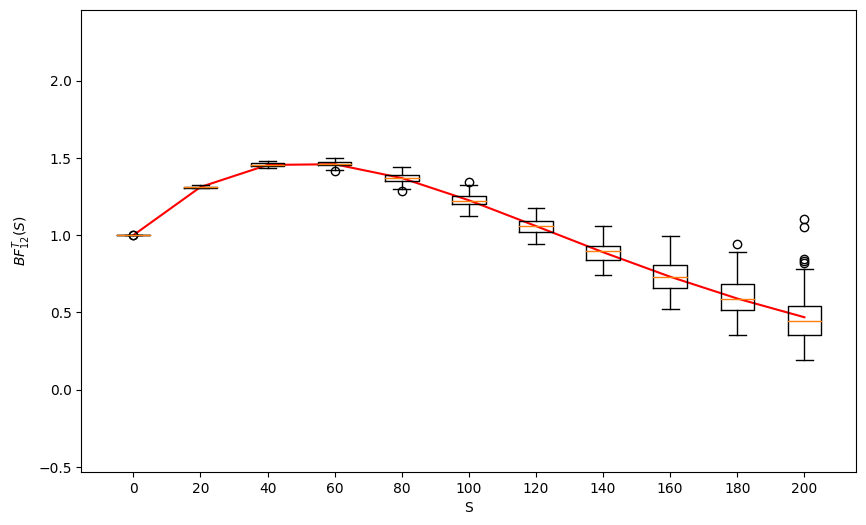

In [1539]:
import matplotlib.pyplot as plt
N = 50
S_list = np.arange(0,4*N+1,(4*N)/10).astype(int)
Theo_list = [np.exp(logBF_theo_S(S,N)) for S in S_list]
print(len(S_list), len(Theo_list), len(Bridge_list))
plt.figure(figsize=(10, 6))  # Adjust the figure size as desired
plt.plot(S_list, Theo_list, color="red")
plt.boxplot(list(test_sim), positions=S_list,widths=10)

plt.xlabel('S')
plt.ylabel('$BF_{12}^{T}(S)$')
plt.ylim(np.min(Theo_list)-1,np.max(Theo_list)+1)
plt.show()


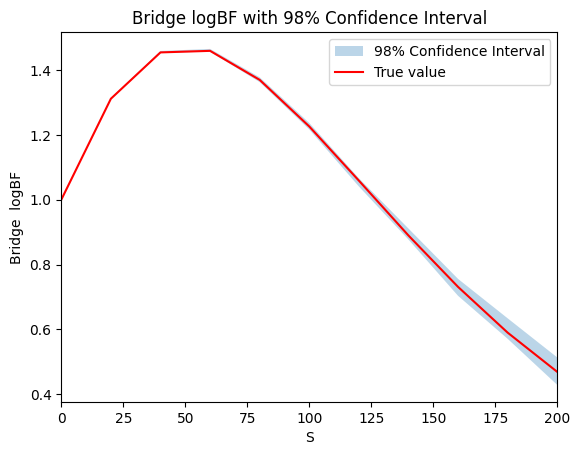

In [1528]:
# Calculate the mean and standard deviation of Bridge_list
N = 50
S_list = np.arange(0,4*N+1,(4*N)/10).astype(int)
mean_bridge = np.mean(test_sim, axis=1)
std_bridge = np.std(test_sim, axis=1)
alpha = 0.01
n_iter = len(test_sim[0])

confidence_interval = norm.ppf(1-alpha/2) * std_bridge / np.sqrt(n_iter)

#plt.plot(S_list, mean_bridge, label='Bridge mean logBF')
plt.fill_between(S_list, mean_bridge - confidence_interval, mean_bridge + confidence_interval, alpha=0.3, label='{}% Confidence Interval'.format(int(100-100*2*alpha)))
plt.plot(S_list, Theo_list, color='red', label='True value')
plt.xlabel('S')
plt.ylabel('Bridge  logBF')
plt.title('Bridge logBF with {}% Confidence Interval'.format(int(100-100*2*alpha)))

plt.legend()
plt.xlim(0,200)
plt.show()


# N = 100

In [1357]:
N = 100

S_list = np.arange(0,4*N+1,(4*N)/10).astype(int)
S_list

array([  0,  40,  80, 120, 160, 200, 240, 280, 320, 360, 400])

In [1371]:
N = 100
S_list = np.arange(0,4*N+1,(4*N)/20).astype(int)
T = 10000
n_iter = 100
Theo_list2, Bridge_list2 = [],[]
logBridge2 = []
for S in tqdm(S_list):
    Bridge_S =[]
    logBridge_S = []
    Theo = np.exp(logBF_theo_S(S,N))
    for _ in tqdm(range(n_iter)):
        X_poiss_S = sample_X_poiss_given_S(S,N,T)
        X_nb_S = sample_X_nbinom_given_S(S,N,T)
        mu_poiss = post_pois_exp(S,N,T)
        mu_nb = post_nbinom_unif(S,N,T)
        l1 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_nb,X_nb_S)])
        l2 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_poiss_S)])
        Bridge = BF_paper(l1,l2)
        Bridge_S.append(Bridge)
        logBridge_S.append(logBF_logsumexp_fixedpoint(l1,l2))
    print("S = {} Theoretical logBF = {} Bridge logBF = {}".format(S,Theo,np.mean(Bridge_S)))
    Theo_list2.append(Theo)
    Bridge_list2.append(Bridge_S)
    logBridge2.append(logBridge_S)
    

  5%|▍         | 1/21 [06:23<2:07:54, 383.72s/it]

S = 0 Theoretical logBF = 1.0 Bridge logBF = 0.9999963276956252


 10%|▉         | 2/21 [14:14<2:17:43, 434.94s/it]

S = 20 Theoretical logBF = 1.1781966048809625 Bridge logBF = 1.177184888853847


 14%|█▍        | 3/21 [22:49<2:21:25, 471.43s/it]

S = 40 Theoretical logBF = 1.3127161347628895 Bridge logBF = 1.3142729077152515


 19%|█▉        | 4/21 [32:38<2:26:42, 517.79s/it]

S = 60 Theoretical logBF = 1.4039190204511083 Bridge logBF = 1.4069068908852205


 24%|██▍       | 5/21 [42:39<2:26:06, 547.88s/it]

S = 80 Theoretical logBF = 1.4551903416535221 Bridge logBF = 1.4562201339285459


 29%|██▊       | 6/21 [52:37<2:21:16, 565.09s/it]

S = 100 Theoretical logBF = 1.4715238352109996 Bridge logBF = 1.4950521001150068


 33%|███▎      | 7/21 [1:03:43<2:19:31, 597.97s/it]

S = 120 Theoretical logBF = 1.4585748701322143 Bridge logBF = 1.4584065557315353


 38%|███▊      | 8/21 [1:14:52<2:14:27, 620.57s/it]

S = 140 Theoretical logBF = 1.422049064366613 Bridge logBF = 1.447883406689913


 43%|████▎     | 9/21 [1:26:03<2:07:15, 636.28s/it]

S = 160 Theoretical logBF = 1.3673279023232554 Bridge logBF = 1.3858197472751141


 48%|████▊     | 10/21 [1:37:22<1:59:04, 649.53s/it]

S = 180 Theoretical logBF = 1.2992588884555987 Bridge logBF = 0.8181874393827474


 52%|█████▏    | 11/21 [1:49:45<1:53:01, 678.13s/it]

S = 200 Theoretical logBF = 1.222057441695529 Bridge logBF = -3.157942663781077


 57%|█████▋    | 12/21 [2:02:16<1:45:01, 700.21s/it]

S = 220 Theoretical logBF = 1.1392824431526853 Bridge logBF = -0.5931097834661068


 62%|██████▏   | 13/21 [2:14:49<1:35:30, 716.37s/it]

S = 240 Theoretical logBF = 1.0538582857209389 Bridge logBF = -0.16890985863813426


 67%|██████▋   | 14/21 [2:27:53<1:25:56, 736.68s/it]

S = 260 Theoretical logBF = 0.9681243542037562 Bridge logBF = 0.6615808443483132


 71%|███████▏  | 15/21 [2:41:33<1:16:10, 761.68s/it]

S = 280 Theoretical logBF = 0.88389878998228 Bridge logBF = -12.886854858733294


 76%|███████▌  | 16/21 [2:55:22<1:05:10, 782.14s/it]

S = 300 Theoretical logBF = 0.802547701707081 Bridge logBF = 0.030050953830416748


 81%|████████  | 17/21 [3:25:14<1:12:22, 1085.74s/it]

S = 320 Theoretical logBF = 0.7250540821190277 Bridge logBF = 0.18916476599727455


 86%|████████▌ | 18/21 [5:46:42<2:45:30, 3310.03s/it]

S = 340 Theoretical logBF = 0.6520828917522234 Bridge logBF = 0.7878212174300627


 90%|█████████ | 19/21 [6:02:46<1:26:51, 2605.51s/it]

S = 360 Theoretical logBF = 0.5840403082908512 Bridge logBF = 0.527327016662651


 95%|█████████▌| 20/21 [6:19:31<35:25, 2125.03s/it]  

S = 380 Theoretical logBF = 0.5211261932503274 Bridge logBF = 0.8755091063323581


100%|██████████| 21/21 [6:37:02<00:00, 1134.41s/it]

S = 400 Theoretical logBF = 0.46337952854965475 Bridge logBF = 0.895649135778352


In [1519]:
import csv

filepath = './data/Poiss_Geo_100.csv'
test_sim2 = []

with open(filepath, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        test_sim2.append(row)
test_sim2 = np.array(test_sim2).astype(float)[1:].T
test_sim2.shape

(11, 100)

11 11 11


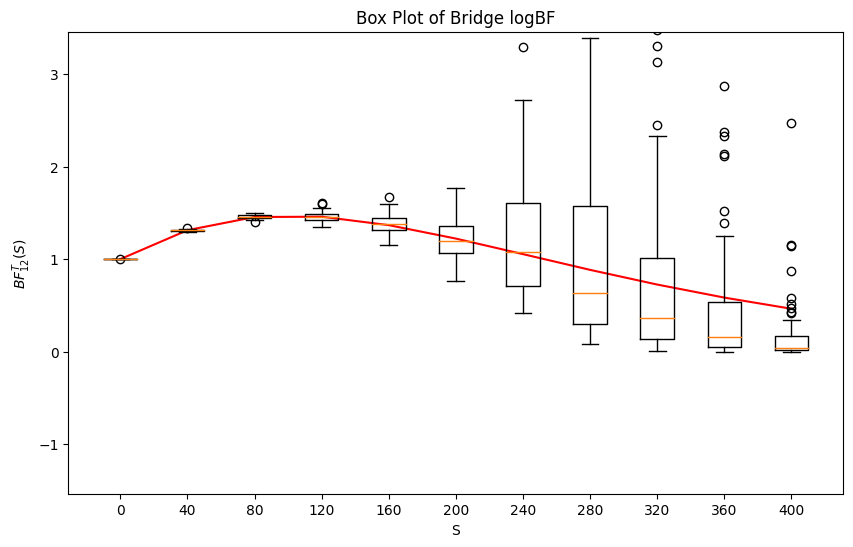

In [1534]:
import matplotlib.pyplot as plt
N = 100
S_list = list(np.arange(0,4*N+1,(4*N)/10).astype(int))
Theo_list2 = list([np.exp(logBF_theo_S(S,N)) for S in S_list])
test_sim2 = list(test_sim2)
print(len(S_list), len(Theo_list2), len(test_sim2))
plt.figure(figsize=(10, 6))  # Adjust the figure size as desired
plt.plot(S_list, Theo_list2, color="red")
plt.boxplot(test_sim2, positions=S_list,widths=20)

plt.xlabel('S')
plt.ylabel('$BF_{12}^{T}(S)$')
plt.title('Box Plot of Bridge logBF')
plt.ylim(np.min(Theo_list2)-2,np.max(Theo_list2)+2)

plt.show()


In [1395]:
np.array(logBridge2).shape

(21, 100)

11 11 21


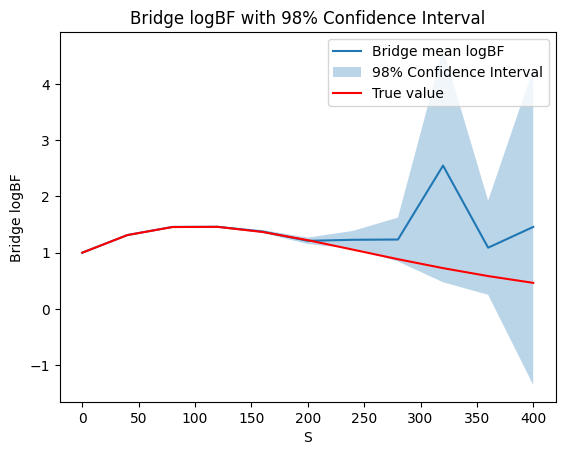

In [1530]:
# Calculate the mean and standard deviation of Bridge_list
N = 100
S_list = np.arange(0,4*N+1,(4*N)/10).astype(int)
mean_bridge = np.mean(test_sim2, axis=1)
std_bridge = np.std(test_sim2, axis=1)
alpha = 0.01
n_iter = len(Bridge_list2[0])
confidence_interval = norm.ppf(1-alpha/2) * std_bridge / np.sqrt(n_iter)
print(len(S_list), len(Theo_list2), len(Bridge_list2))
plt.plot(S_list, mean_bridge, label='Bridge mean logBF')
plt.fill_between(S_list, mean_bridge - confidence_interval, mean_bridge + confidence_interval, alpha=0.3, label='{}% Confidence Interval'.format(int(100-100*2*alpha)))
plt.plot(S_list, Theo_list2, color='red', label='True value')
plt.xlabel('S')
plt.ylabel('Bridge logBF')
plt.title('Bridge logBF with {}% Confidence Interval'.format(int(100-100*2*alpha)))

plt.legend()
plt.show()


## N = 1000

In [1558]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [1548]:
N = 500
S_list = np.arange(0,4*N+1,(4*N)/5).astype(int)
T = 100000
n_iter = 10
Theo_list3, Bridge_list3 = [],[]
logBridge3 = []
L1, L2 = [],[]
for S in tqdm(S_list):
    Bridge_S =[]
    logBridge_S = []
    L1_S, L2_S = [],[]
    Theo = np.exp(logBF_theo_S(S,N))
    print('Theoretical BF: {} logBF: {}'.format(Theo,np.log(Theo)))
    for _ in tqdm(range(n_iter)):
        X_poiss_S = sample_X_poiss_given_S(S,N,T)
        X_nb_S = sample_X_nbinom_given_S(S,N,T)
        mu_poiss = post_pois_exp(S,N,T)
        mu_nb = post_nbinom_unif(S,N,T)
        l1 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_poiss_S)])
        l2 = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_nb,X_nb_S)])
        L1_S.append(l1)
        L2_S.append(l2)
        print('Bridge...l1 = {} l2 = {}',end='')   
        Bridge = BF_paper(l1,l2)
        Bridge_S.append(Bridge)
        logBridge_S.append(logBF_paper(l1,l2))
        print("BF = {} with log BF = {}".format(Bridge,logBF_paper(l1,l2)))
    print("S = {} Theoretical logBF = {} Bridge logBF = {}".format(S,Theo,np.mean(Bridge_S)))
    Theo_list3.append(Theo)
    Bridge_list3.append(Bridge_S)
    logBridge3.append(logBridge_S)
    L1.append(L1_S)
    L2.append(L2_S)
    

  0%|          | 0/6 [00:00<?, ?it/s]

Theoretical BF: 1.0 logBF: 0.0


Bridge...

BF = 0.9999963667453535 with log BF = -3.6332612474154757e-06
Bridge...

BF = 0.9999873760331612 with log BF = -1.2624046521025889e-05
Bridge...

BF = 1.0000043143060258 with log BF = 4.3142967189879755e-06
Bridge...

BF = 0.9999999397942971 with log BF = -6.020570353371113e-08
Bridge...

BF = 1.0000066496741415 with log BF = 6.649652034340647e-06
Bridge...

BF = 1.0000029047774415 with log BF = 2.9047732219567024e-06
Bridge...

BF = 1.0000026918321805 with log BF = 2.691828557388476e-06
Bridge...

BF = 0.9999938543480021 with log BF = -6.1456708824181305e-06
Bridge...

BF = 0.9999959413145683 with log BF = -4.058693667374769e-06
Bridge...

 17%|█▋        | 1/6 [08:49<44:07, 529.50s/it]

BF = 1.0000101589179209 with log BF = 1.015886631951921e-05
S = 0 Theoretical logBF = 1.0 Bridge logBF = 1.000000019774309
Theoretical BF: 1.4556969019351984 logBF: 0.3754847563559451


Bridge...

BF = 2.719526785959468 with log BF = 1.0004578894221738
Bridge...

BF = 0.7093516741852037 with log BF = -0.34340386105888104
Bridge...

BF = 4.661238788680008 with log BF = 1.539281247290518
Bridge...

BF = 4.714562365843213 with log BF = 1.55065609435306
Bridge...

BF = 0.8639457018429562 with log BF = -0.14624535724208798
Bridge...

BF = 0.7096801787738385 with log BF = -0.3429408628621632
Bridge...

BF = 0.6707182969388896 with log BF = -0.3994060558864039
Bridge...

BF = 1.1383897840999129 with log BF = 0.12961479384241167
Bridge...

BF = 1.5305776718523878 with log BF = 0.42564522744747
Bridge...

 33%|███▎      | 2/6 [22:46<47:21, 710.26s/it]

BF = 2.7643524270531477 with log BF = 1.016806403946938
S = 400 Theoretical logBF = 1.4556969019351984 Bridge logBF = 2.0482343675229027
Theoretical BF: 1.365323903345312 logBF: 0.31139169231573754


Bridge...

BF = 0.20641987315179827 with log BF = -1.5778429653596149
Bridge...

BF = 0.004236979753351664 with log BF = -5.463904585883079
Bridge...

BF = 0.00969323033496242 with log BF = -4.636327540733014
Bridge...

BF = 0.046337174798644146 with log BF = -3.071810728633089
Bridge...

BF = 0.03564131757259938 with log BF = -3.334249708134711
Bridge...

BF = 0.014127644936876987 with log BF = -4.2596217673108505
Bridge...

BF = 0.0010058230522136046 with log BF = -6.901949115207284
Bridge...

BF = 0.050134511562305445 with log BF = -2.993045654502985
Bridge...

BF = 0.0003296546720308124 with log BF = -8.017464899804615
Bridge...

 50%|█████     | 3/6 [35:37<36:53, 737.88s/it]

BF = 0.0026799517674162736 with log BF = -5.92195648185406
S = 800 Theoretical logBF = 1.365323903345312 Bridge logBF = 0.0370606161602199
Theoretical BF: 1.0497349751862273 logBF: 0.04853772772548831


Bridge...

BF = 8.32370091132655e-08 with log BF = -16.301573766949915
Bridge...

BF = 6.262443616976895e-08 with log BF = -16.58611028085905
Bridge...

BF = 0.00014525834560642653 with log BF = -8.836996707039967
Bridge...

BF = 4.777752683131203e-11 with log BF = -23.76446573695885
Bridge...

BF = 3.297967204675327e-12 with log BF = -26.437714835844428


 50%|█████     | 3/6 [43:38<43:38, 872.99s/it]


KeyboardInterrupt: 

In [1556]:
import line_profiler

# Create a line profiler object
profiler = line_profiler.LineProfiler()
S,N,T = 1000,500,10000
# Add the function to be profiled
profiler.add_function(func_BF((0, S, N, T)))

# Run the profiler on the function
profiler.run('func_BF((0, S, N, T))')

# Print the profiling results
profiler.print_stats()


/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Could not extract a code object for the object 9.04886025123336e-07
  import sys


Timer unit: 1e-09 s



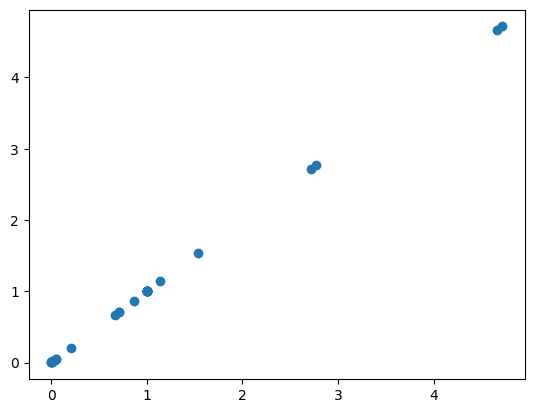

In [1549]:
plt.scatter(Bridge_list3,np.exp(logBridge3))

(-1.0, 3.455696901935198)

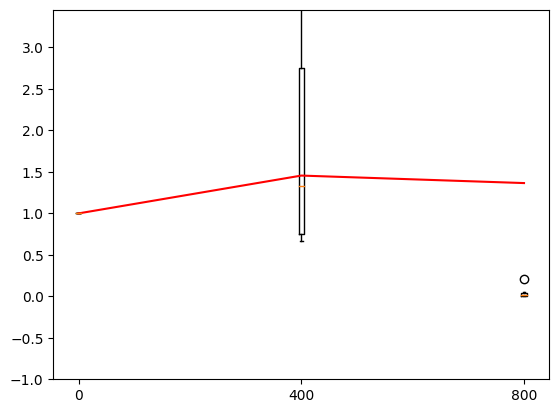

In [1550]:
plt.boxplot(Bridge_list3, positions=S_list[:len(Bridge_list3)],widths=10)
plt.plot(S_list[:len(Bridge_list3)], Theo_list3[:len(Bridge_list3)], color="red")
plt.ylim(np.min(Theo_list3[:len(Bridge_list3)])-2,np.max(Theo_list3[:len(Bridge_list3)])+2)

ValueError: x and y must have same first dimension, but have shapes (21,) and (3,)

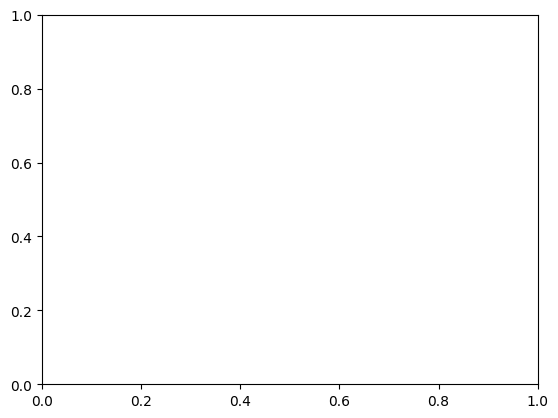

In [1382]:
# Calculate the mean and standard deviation of Bridge_list
N = 1000
S_list = np.arange(0,4*N+1,(4*N)/20).astype(int)
mean_bridge = np.mean(Bridge_list3, axis=1)

std_bridge = np.std(Bridge_list3, axis=1)

alpha = 0.1
n_iter = len(Bridge_list3[0])
confidence_interval = norm.ppf(1-alpha/2) * std_bridge / np.sqrt(n_iter)

plt.plot(S_list, mean_bridge, label='Bridge logBF')
plt.fill_between(S_list, mean_bridge - confidence_interval, mean_bridge + confidence_interval, alpha=0.3, label='{}% Confidence Interval'.format(int(100-100*2*alpha)))
#plt.plot(S_list, Theo_list3, color='red', label='True value')
plt.xlabel('S')
plt.ylabel('Bridge logBF')
plt.title('Bridge logBF with {}% Confidence Interval'.format(int(100-100*2*alpha)))

plt.legend()
plt.xlim(0,400)
plt.show()


# RE computation


In [1163]:
def RE_func(mu,S, N):
    return 1/(2/betaprime(S+1,N+1).pdf(mu)+2/gamma(S+1,scale=1/(N+1)).pdf(mu))

In [1231]:
N = 1009
T = 10000

S_list = np.arange(0,4*N,20)
RE_list = []
for S in S_list:
    RE = 1/quad(RE_func, 0, np.inf, args=(S,N))[0]- 2
    #print("S = {} RE = {}".format(S,RE))
    RE_list.append(RE)
plt.plot(S_list, RE_list)

/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  


KeyboardInterrupt: 

In [1050]:
Gamma = []
Beta = []
N = 50
eps=.001
for S in tqdm(S_list):
    law_b = betaprime(S+1,N+1)
    law_g = gamma(S+1,scale=1/(N+1))
    Gamma.append([law_g.ppf(eps),law_g.ppf(1-eps)])
    Beta.append([law_b.ppf(eps),law_b.ppf(1-eps)])
    

100%|██████████| 150/150 [00:00<00:00, 338.22it/s]


# Overlap $\pi(\theta\mid y)$


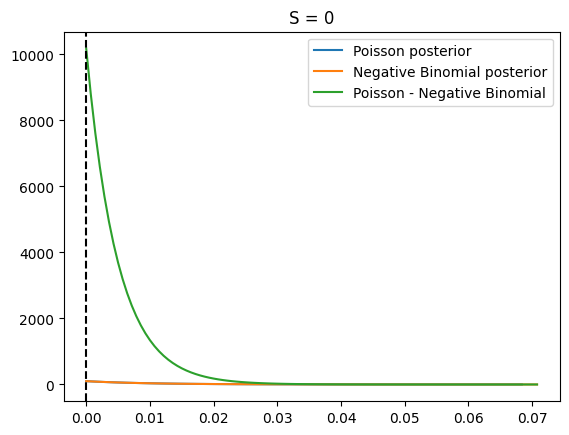

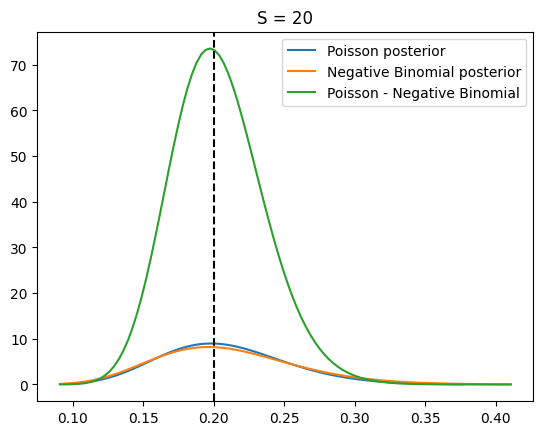

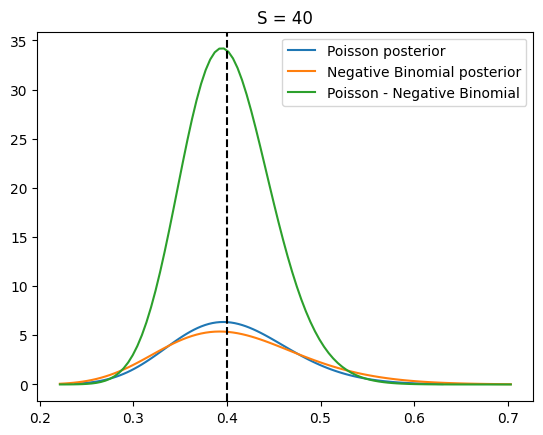

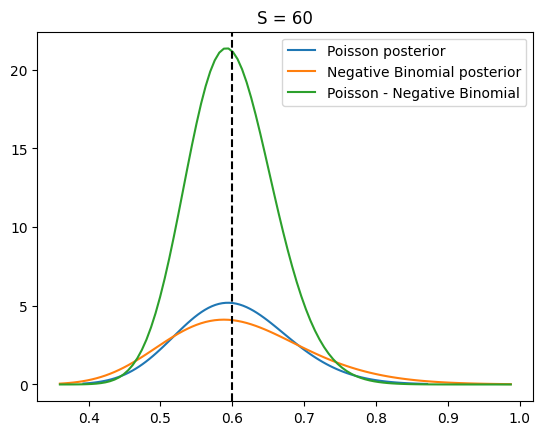

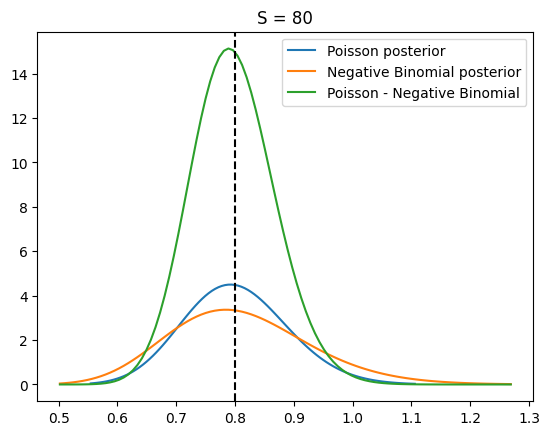

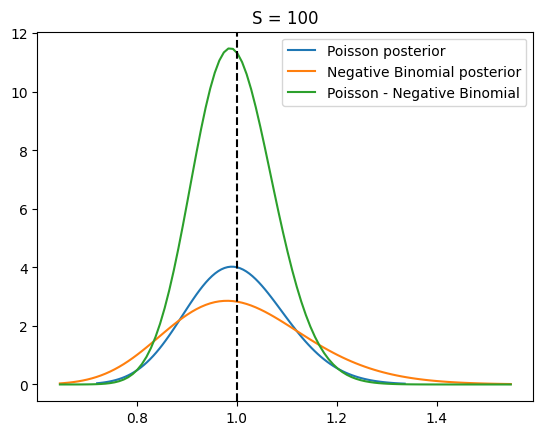

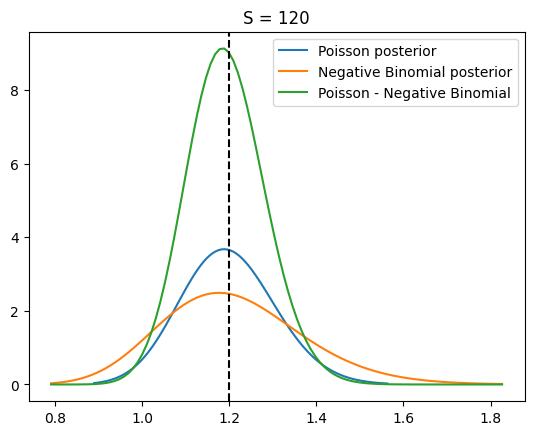

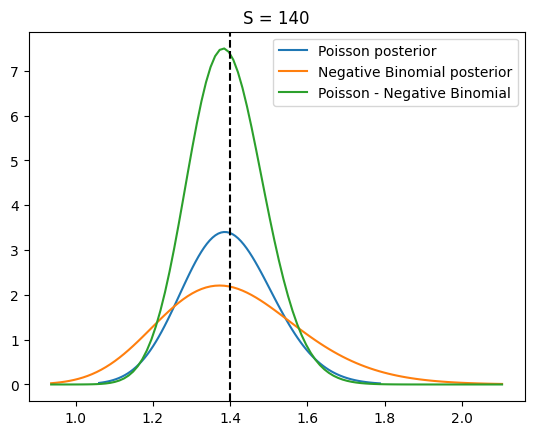

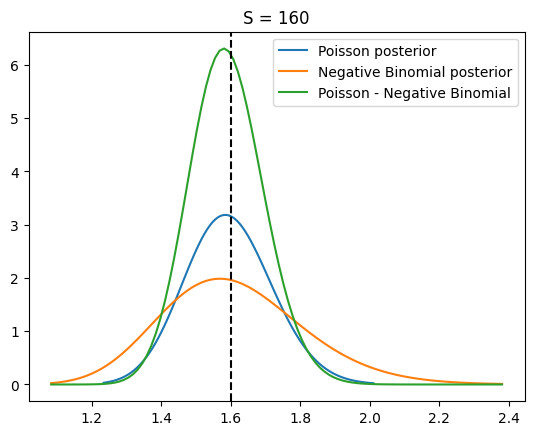

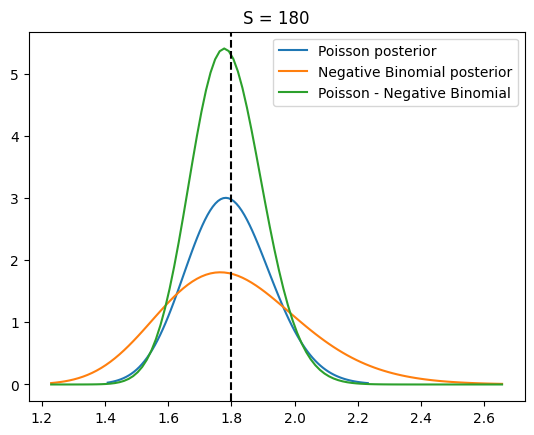

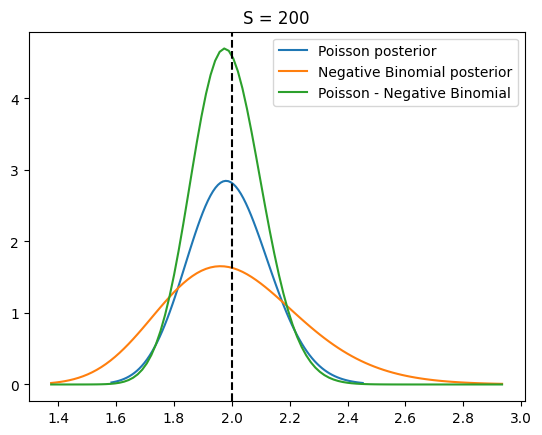

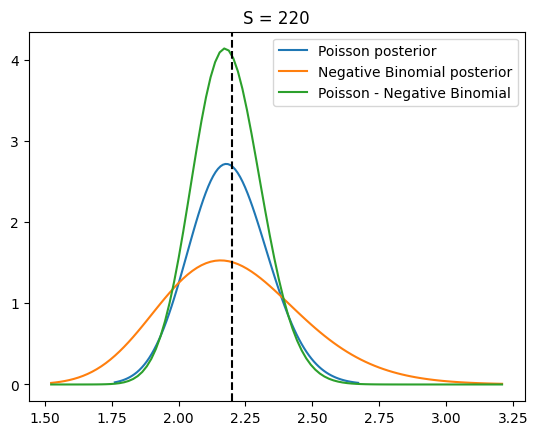

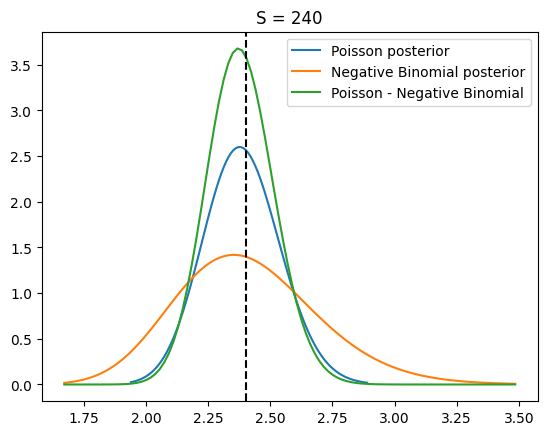

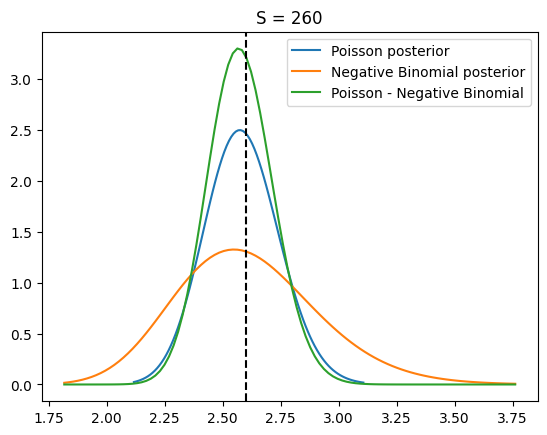

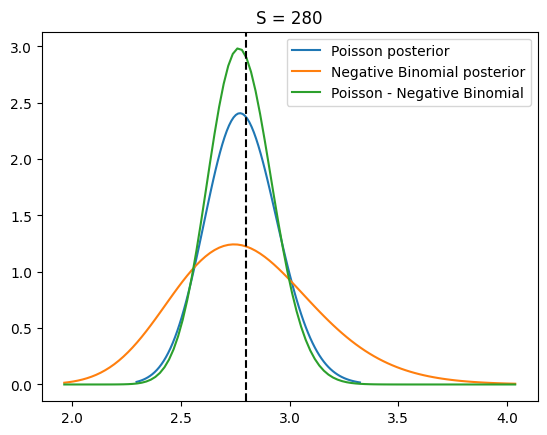

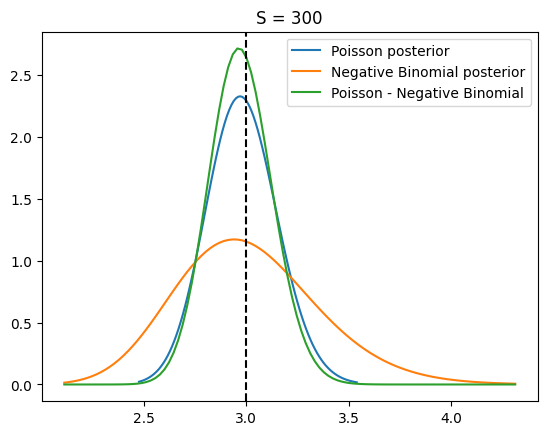

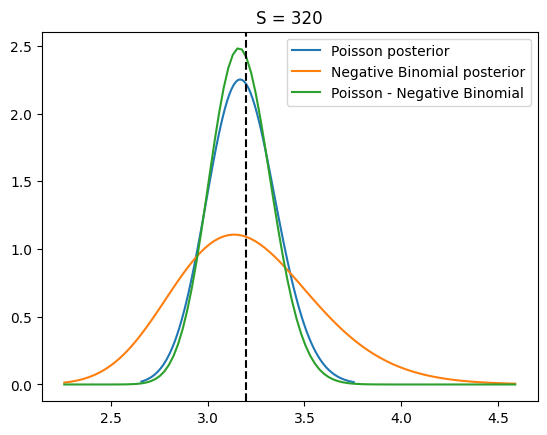

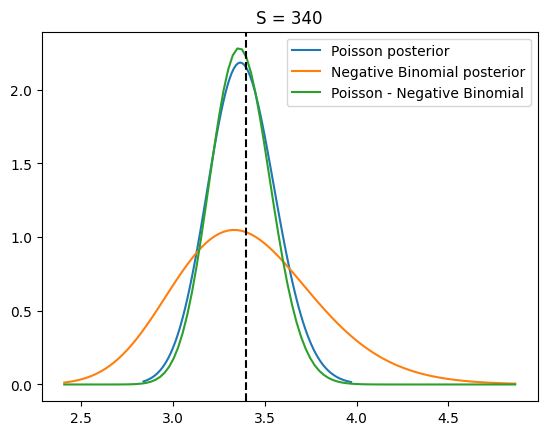

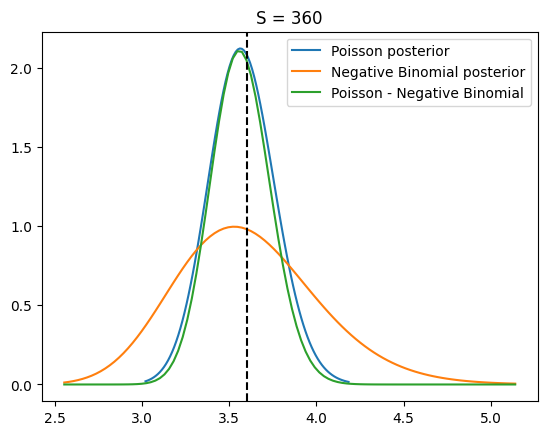

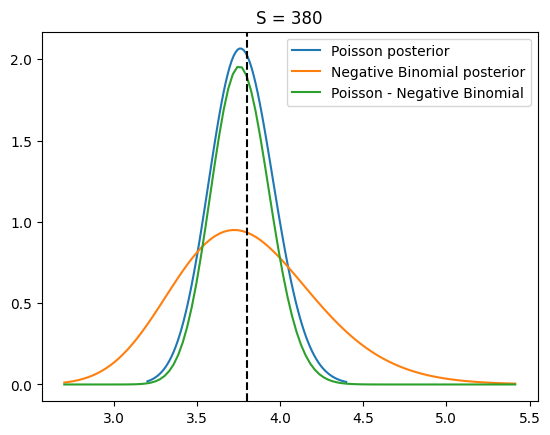

In [1196]:
N = 100
S_list = np.arange(0,4*N,20)
for S in S_list:
    law1 = gamma(S+1,scale=1/(N+1))
    x = np.linspace(law1.ppf(0.001),law1.ppf(0.999), 100)
    plt.plot(x, law1.pdf(x), label="Poisson posterior")
    law2 = betaprime(S+1,N+1)
    x = np.linspace(law2.ppf(0.001),law2.ppf(0.999), 100)
    plt.plot(x, law2.pdf(x), label="Negative Binomial posterior")
    x = np.linspace(min(law1.ppf(0.001),law2.ppf(0.001)),max(law1.ppf(0.999),law2.ppf(0.999)), 100)
    plt.plot(x, law1.pdf(x)*law2.pdf(x), label="Poisson - Negative Binomial")
    plt.axvline(S/N, color="black", linestyle="--")
    plt.plot()
    plt.title("S = {}".format(S))
    plt.legend()
    plt.show()

In [1181]:
quad(lambda x: gamma(S+1, scale=1/(N+1)).pdf(x), 0, np.inf)

(0.999999999999988, 1.490209487301561e-09)

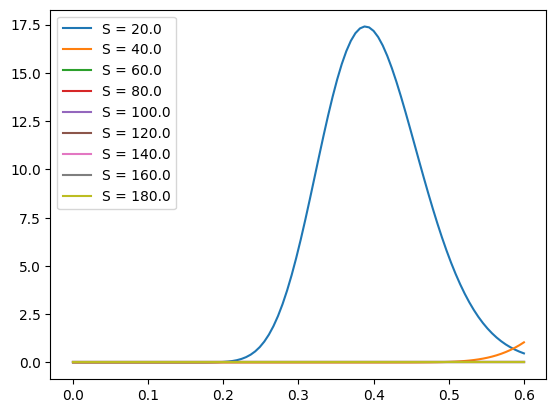

In [1194]:
x = np.linspace(0,.6,100)
N = 50
S_list = np.arange(0,4*N,4*N/10)
for S in S_list[1:]:
    plt.plot(x,gamma(S+1,scale=1/(N+1)).pdf(x)*betaprime(S+1,N+1).pdf(x), label="S = {}".format(S))
plt.legend()

In [1179]:
N = 50
S_list = np.arange(0,4*N,4*N/100)
overlap50 = [quad(lambda x: gamma(S+1,scale=1/(N+1)).pdf(x)*betaprime(S+1,N+1).pdf(x), 0, np.inf)[0] for S in tqdm(S_list)]

N = 100
S_list = np.arange(0,4*N,4*N/100)
overlap100 = [quad(lambda x: gamma(S+1,scale=1/(N+1)).pdf(x)*betaprime(S+1,N+1).pdf(x), 0, np.inf)[0] for S in tqdm(S_list)]

N = 1000
S_list = np.arange(0,4*N,4*N/100)
overlap1000 = [quad(lambda x: gamma(S+1,scale=1/(N+1)).pdf(x)*betaprime(S+1,N+1).pdf(x), 0, np.inf)[0] for S in tqdm(S_list)]



100%|██████████| 100/100 [00:24<00:00,  4.11it/s]


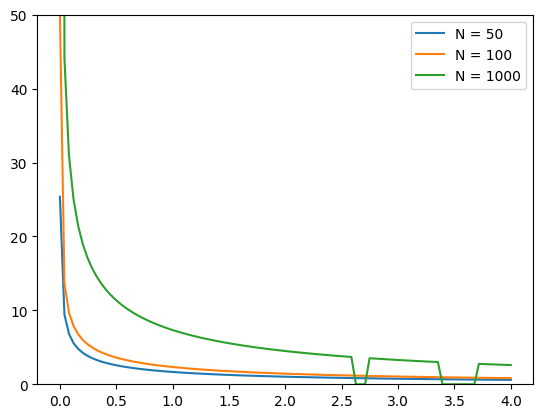

In [1235]:
mu_list =np.linspace(0,4,100)
plt.plot(mu_list, overlap50, label="N = 50")
plt.plot(mu_list, overlap100, label="N = 100")
plt.plot(mu_list, overlap1000, label="N = 1000")
plt.ylim(0,50)
plt.legend()

# Overlap $y$

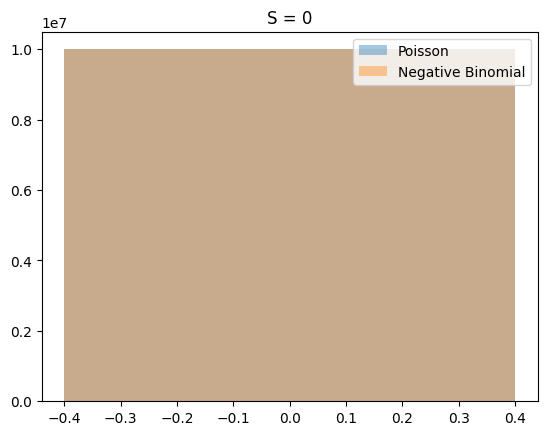

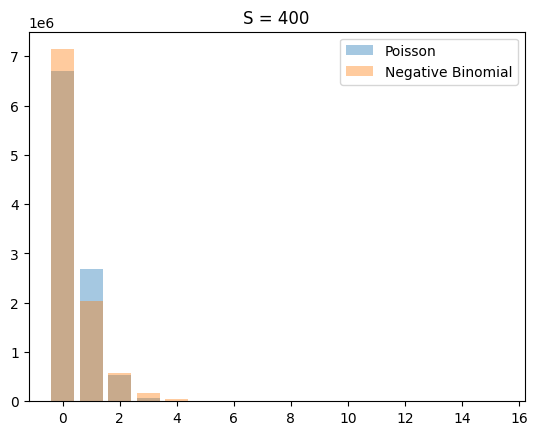

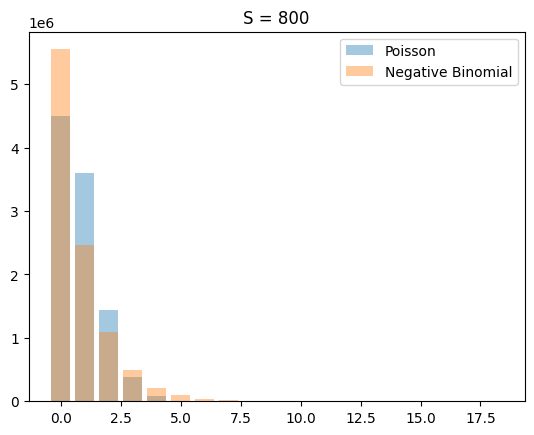

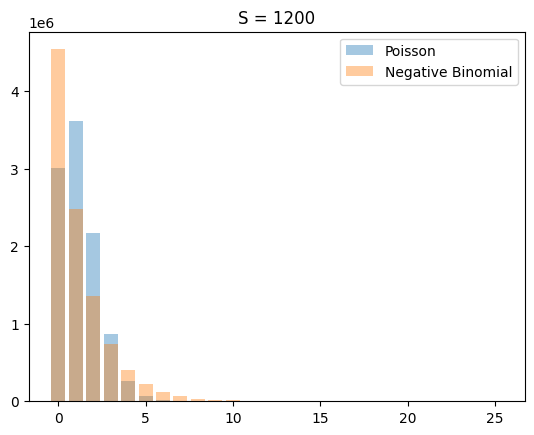

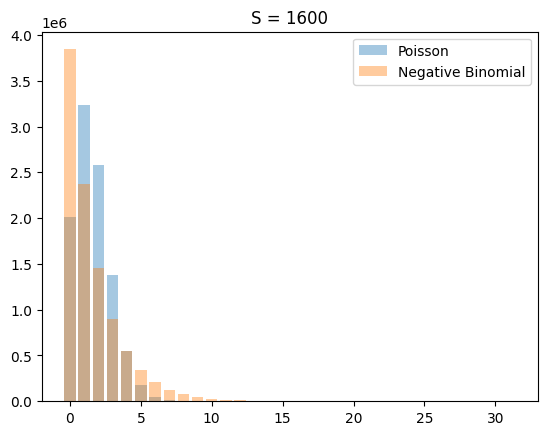

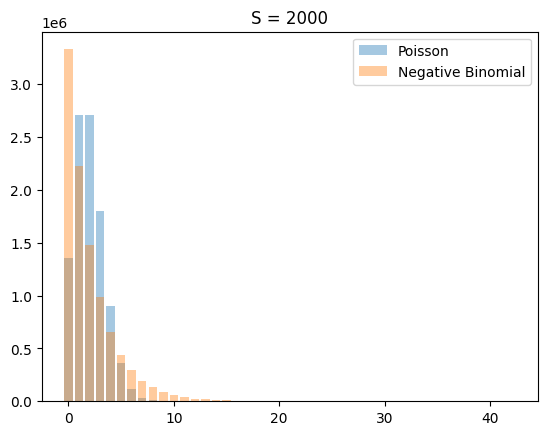

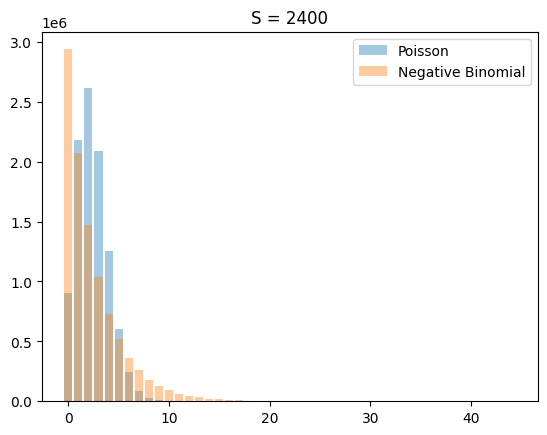

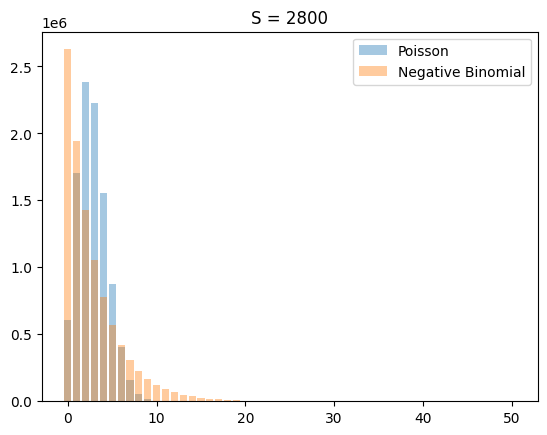

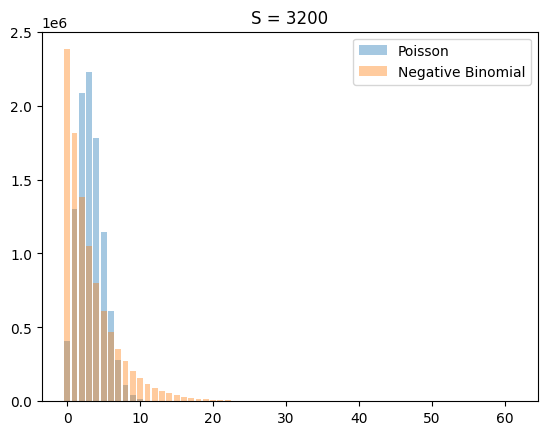

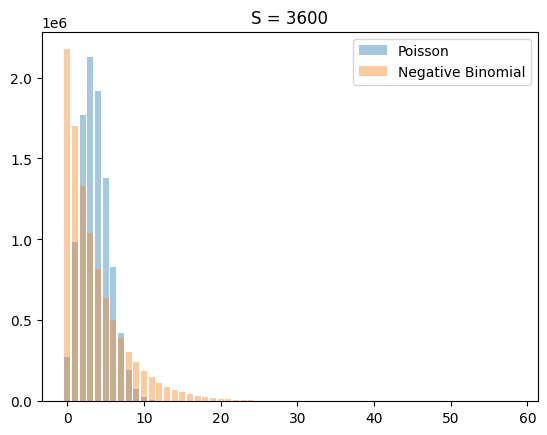

In [1243]:
N = 1000
S_list = np.arange(0,4*N,4*N/10).astype(int)
for S in S_list:
    X_pois = sample_X_poiss_given_S(S,N,10000)
    X_geo = sample_X_nbinom_given_S(S,N,10000)
    value_pois, counts_pois = np.unique(X_pois, return_counts=True)
    value_geo, counts_geo = np.unique(X_geo, return_counts=True)
    plt.bar(value_pois, counts_pois, label="Poisson",alpha=.4)
    plt.bar(value_geo, counts_geo, label="Negative Binomial",alpha=.4)
   
    plt.title("S = {}".format(S))
    plt.legend()
    plt.show()
    


Text(0.5, 0, 'S')

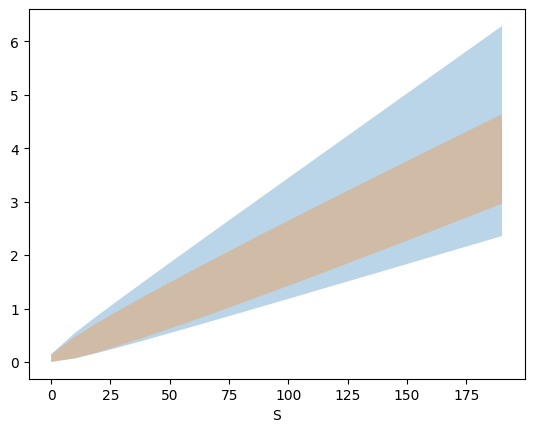

In [1144]:
N = 50 
S_list = np.arange(0,4*N,10)
Q_gamma,Q_beta= [],[]
for S in S_list: 
    law = gamma(S+1,scale=1/(N+1))
    Q_gamma.append([law.ppf(eps),law.ppf(1-eps)])
    law = betaprime(S+1,N+1)
    Q_beta.append([law.ppf(eps),law.ppf(1-eps)])
    
Q_gamma = np.array(Q_gamma)
Q_beta = np.array(Q_beta)

plt.fill_between(S_list, Q_beta[:,0], Q_beta[:,1], alpha=0.3, label='Quantile 99% Beta')
plt.fill_between(S_list, Q_gamma[:,0], Q_gamma[:,1], alpha=0.3, label='Quantile 99% Gamma')

plt.xlabel("S")


In [1051]:
B_mean = []
G_mean = []
N = 50
for S 

100%|██████████| 150/150 [00:00<00:00, 1256.80it/s]


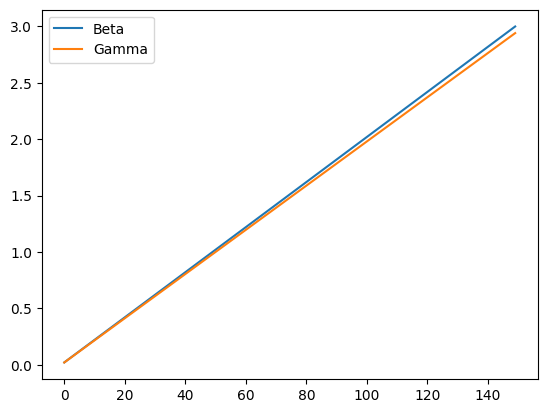

In [1052]:
plt.plot(S_list,B_mean, label="Beta")
plt.plot(S_list,G_mean, label="Gamma")
plt.legend()


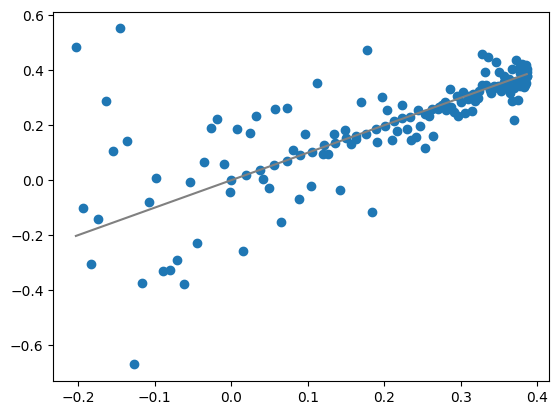

In [1054]:
plt.scatter(Theo_list, Bridge_list, label="Poisson")
x = np.linspace(np.min(Theo_list),np.max(Theo_list),1000)
plt.plot(x,x, color="grey")


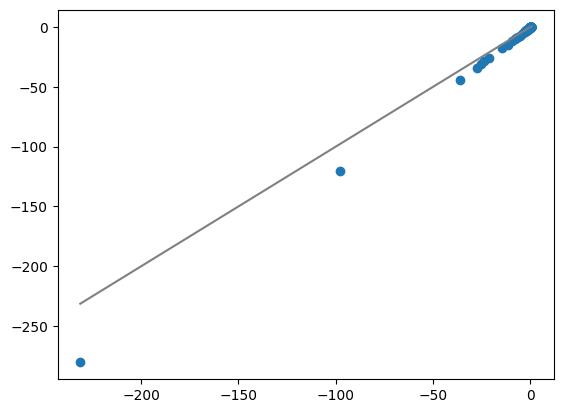

In [ ]:
plt.scatter(Theo_NB, Bridge_NB, label="Negative Binomial")
x=np.linspace(np.min(Theo_NB),np.max(Theo_NB),100)
plt.plot(x,x, color="grey")

In [ ]:
N = 1000
n_iter= 100
T = 10000
Bridge_Poiss2, Bridge_NB2 = [],[],[],[]
S = 100
theo = logBF_theo_S(S,N)
for _ in tqdm(range(n_iter)):
    theo_nb = logBF_theo_S(S_nb,N)
    mu_nb = post_nbinom_unif(S_nb,N,T)
    mu_poiss = post_pois_exp(S_nb,N,T)
    lratio_num = -np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_nb,X_nb)])
    lratio_den = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_nb)])
    Bridge_nb = logBF_logsumexp_fixedpoint(lratio_num,lratio_den)
    print("Nbinom S = {} Theoretical logBF = {} Bridge logBF = {}".format(S_nb,theo_nb,Bridge_nb))
    
    p = np.random.uniform(size=1)
    mu = expon(1).rvs(1)
    X_pois = poisson.rvs(mu, size=N)
    S_pois = np.sum(X_pois)
    mu_nb = post_nbinom_unif(S_pois,N,T)
    mu_poiss = post_pois_exp(S_pois,N,T)
    lratio_num = -np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_nb,X_pois)])
    lratio_den = np.array([logratio_pois_nb(mu,X) for mu,X in zip(mu_poiss,X_pois)])
    Bridge_pois = logBF_logsumexp_fixedpoint(lratio_num,lratio_den)
    print("Poisson S = {} Theoretical logBF = {} Bridge logBF = {}".format(S_pois,theo_pois,Bridge_pois))
    
    Bridge_Poiss2.append(Bridge_pois)
    Bridge_NB2.append(Bridge_nb)
    